In [25]:
import re, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from sklearn.isotonic import IsotonicRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import networkx as nx

from pyod.models.hbos import HBOS
from pyod.models.copod import COPOD

np.random.seed(42)
import hashlib

In [26]:
df = pd.read_excel('data/final_risk_data.xlsx')

# --- Автоматическая генерация txn_id (если нет в файле) ---
def make_txn_id(row):
    """
    Хешируем минимальный набор полей, чтобы получить устойчивый уникальный txn_id.
    Если поле пустое, подставляем None.
    """
    parts = [
        str(row.get('date', '')),
        str(row.get('debit_inn', '')),
        str(row.get('credit_inn', '')),
        str(row.get('amount', '')),
        str(row.get('purpose', ''))
    ]
    raw = "||".join(parts)
    return hashlib.sha256(raw.encode('utf-8')).hexdigest()



# изменение типов данных
df['date'] = pd.to_datetime(df['date']).dt.normalize()
for i in ['debit_amount', 'credit_amount']:
    if i in df.columns:
        df[i] = pd.to_numeric(df[i], errors='coerce')
        
# создание колонки с суммой операции
df["amount"] = np.where(df["debit_amount"].notna(), df["debit_amount"], df["credit_amount"])
df["debit_amount"] = df["debit_amount"].fillna(0.0)
df["credit_amount"] = df["credit_amount"].fillna(0.0)

# созжание временных признаков
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
df['month'] = df['date'].dt.month
df["weekofyear"]   = df["date"].dt.isocalendar().week.astype(int)

# Суточные фичи
df['daily_total_debit'] = df.groupby(['debit_inn', 'date'])['debit_amount'].transform('sum')
df['daily_total_credit'] = df.groupby(['credit_inn', 'date'])['credit_amount'].transform('sum')
# посчет транзакций за сутки
df["daily_debit_transaction_count"]    = df.groupby(["debit_inn","date"])["debit_amount"].transform(lambda s: (s > 0).sum())
df["daily_credit_transaction_count"]    = df.groupby(["credit_inn","date"])["credit_amount"].transform(lambda s: (s > 0).sum())
# уникальные отправители и получатели в сутки
df["unique_recipients_per_day"] = df.groupby(["debit_inn","date"])["credit_inn"].transform("nunique")
df["unique_receivers_per_day"] = df.groupby(["credit_inn","date"])["debit_inn"].transform("nunique")

# Доля текущей операции в суточном объёме
df["daily_debit_percent"] = (df["debit_amount"] / df["daily_total_debit"].replace(0, np.nan)).fillna(0.0)
df["daily_credit_percent"] = (df["credit_amount"] / df["daily_total_credit"].replace(0, np.nan)).fillna(0.0)

# Интервалы между операциями (в днях)
df["days_since_last_txn_debit"]  = df.groupby("debit_inn")["date"].diff().dt.days.fillna(9999)
df["days_since_last_txn_credit"] = df.groupby("credit_inn")["date"].diff().dt.days.fillna(9999)

def add_rolling_side(df: pd.DataFrame,
                     side: str,
                     amt_col: str,
                     windows=(7, 14, 30, 90)) -> pd.DataFrame:
    """
    Создает роллинги по суммам/кол-ву транзакций за окна windows для заданной стороны.
    side: 'debit' или 'credit'
    amt_col: имя столбца с суммой для этой стороны (например, 'debit_amount' / 'credit_amount')
    """
    inn_col = f"{side}_inn"
    out_parts = []

    # Берем только нужные колонки (ускоряет groupby)
    need_cols = [inn_col, "date", amt_col]
    sub_all = df[need_cols].copy()
    sub_all[amt_col] = sub_all[amt_col].fillna(0.0)

    for inn, sub in sub_all.groupby(inn_col, sort=False):
        # суточная агрегация по аккаунту
        daily = (sub.groupby("date", as_index=True)[amt_col]
                   .sum()
                   .to_frame("amt_day")
                   .sort_index())

        # непрерывный календарный индекс (чтобы окна не "сжимались")
        idx = pd.date_range(daily.index.min(), daily.index.max(), freq="D")
        daily = daily.reindex(idx, fill_value=0.0)
        daily.index.name = "date"

        # индикатор "была ли операция в день" (для роллинга количества)
        daily["tx_day"] = (daily["amt_day"] > 0).astype(int)

        # роллинги
        for W in windows:
            daily[f"{side}_roll_sum_{W}d"]  = daily["amt_day"].rolling(W, min_periods=1).sum()
            daily[f"{side}_roll_cnt_{W}d"]  = daily["tx_day"].rolling(W, min_periods=1).sum()
            daily[f"{side}_roll_mean_{W}d"] = daily["amt_day"].rolling(W, min_periods=1).mean()
            daily[f"{side}_roll_std_{W}d"]  = daily["amt_day"].rolling(W, min_periods=1).std().fillna(0.0)
            daily[f"{side}_roll_p95_{W}d"]  = daily["amt_day"].rolling(W, min_periods=1).quantile(0.95)

        daily = daily.reset_index()
        daily[inn_col] = inn
        out_parts.append(daily[["date", inn_col] + [c for c in daily.columns if c.startswith(f"{side}_roll_")]])

    rolls = pd.concat(out_parts, ignore_index=True)
    return df.merge(rolls, on=["date", inn_col], how="left")



# Новые роллинги 7/14/30/90 для дебета и кредита
WINDOWS = (7, 14, 30, 90)
df = add_rolling_side(df, side="debit",  amt_col="debit_amount",  windows=WINDOWS)
df = add_rolling_side(df, side="credit", amt_col="credit_amount", windows=WINDOWS)

# ==== 1. Всплески сумм (amount_spike_ratio_7d) ====
df["debit_amount_spike_ratio_7d"]  = df["debit_roll_sum_7d"]  / (df["debit_roll_sum_30d"]/4 + 1e-6)
df["credit_amount_spike_ratio_7d"] = df["credit_roll_sum_7d"] / (df["credit_roll_sum_30d"]/4 + 1e-6)

# ==== 2. Всплески активности (tx_rate_spike_7d) ====
df["debit_tx_rate_spike_7d"]  = df["debit_roll_cnt_7d"]  / (df["debit_roll_cnt_30d"]/4 + 1e-6)
df["credit_tx_rate_spike_7d"] = df["credit_roll_cnt_7d"] / (df["credit_roll_cnt_30d"]/4 + 1e-6)

# ==== 3. Fan-out / Fan-in (уникальные контрагенты) ====
# Для дебета — fan-out (сколько разных получателей на операцию)
df["debit_fan_out_ratio"] = df["unique_recipients_per_day"] / (df["daily_debit_transaction_count"] + 1e-6)

# Для кредита — fan-in (сколько разных отправителей на операцию)
df["credit_fan_in_ratio"] = (
    df.groupby(["credit_inn", "date"])["debit_inn"].transform("nunique") /
    (df["daily_credit_transaction_count"] + 1e-6)
)

# ==== 4. Дисбаланс потоков (in_out_ratio_30d) ====
df["in_out_ratio_30d"] = (df["credit_roll_sum_30d"] + 1e-6) / (df["debit_roll_sum_30d"] + 1e-6)

# ==== 5. Волатильность объёмов (amount_volatility_30d) ====
df["debit_amount_volatility_30d"]  = df["debit_roll_std_30d"]  / (df["debit_roll_mean_30d"]  + 1e-6)
df["credit_amount_volatility_30d"] = df["credit_roll_std_30d"] / (df["credit_roll_mean_30d"] + 1e-6)


# Круглые суммы
df["round_10k"]  = ((df["amount"] % 10000)  == 0).astype(int)
df["round_100k"] = ((df["amount"] % 100000) == 0).astype(int)
df["round_large_amount"] = ((df["round_10k"]==1) | (df["round_100k"]==1)).astype(int)


if 'txn_id' not in df.columns:
    df['txn_id'] = df.apply(make_txn_id, axis=1)
df.head()


,date,debit_account,debit_name,debit_inn,credit_account,credit_name,credit_inn,debit_amount,credit_amount,purpose,...,credit_tx_rate_spike_7d,debit_fan_out_ratio,credit_fan_in_ratio,in_out_ratio_30d,debit_amount_volatility_30d,credit_amount_volatility_30d,round_10k,round_100k,round_large_amount,txn_id
0,2019-01-09,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,0c00203649ed677a,e19cc80da09f445f,8d9e0be733f77f1c,10.0,0.0,комиссия внутри сбербанка за пп/пт через дбо с...,...,0.000000,1.0,1000000.0,3.333322e-13,0.000000,0.0,0,0,0,2166136e096d8a25357f144893bc671c843a44fe0c1573...
1,2019-01-09,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,7682fd5c32e028f5,796a88c244ffcc0a,6931e23e98703aa9,3000000.0,0.0,оплата по счету № 28 от date_9f241b636025 по д...,...,0.000000,1.0,1000000.0,3.333322e-13,0.000000,0.0,1,1,1,a3ae40ed83928974a81d8404781505bdb639cfbefbeebb...
2,2019-01-10,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,0c00203649ed677a,e19cc80da09f445f,8d9e0be733f77f1c,10.0,0.0,комиссия внутри сбербанка за пп/пт через дбо с...,...,0.000000,1.0,1000000.0,3.328560e-13,1.410173,0.0,0,0,0,bc1aa953c6fa95aafd76cf203fdb79a8d61e026bcbb588...
3,2019-01-10,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,e63cf19b76230a3d,21a73421ca00ae87,eed8b1f54ed4366c,4282.0,0.0,оплата по договору электроэнергия по дог.№1124...,...,0.000000,1.0,1000000.0,3.328560e-13,1.410173,0.0,0,0,0,2f310c6d6d75414f413e93585fddcb339528066a9c1e0e...
4,2019-01-10,d658b4e51c5a5df5,f7185cc66db08da5,ad57c94e5b8df8f6,ded93f97f389bf2c,3e368a63959d285e,d877722ca4e40f98,0.0,1000000.0,перевод денежных средств по договору займа № ч...,...,3.999984,1000000.0,1.0,3.000000e+12,0.000000,0.0,1,1,1,b0c90e36952a4dd06e0a25f627e509c9d31ab7c7272897...


In [27]:
# ============================================================
#  Анализ "Назначения платежа": TF-IDF (char 3–5) + стоп-слова риска
# ============================================================

import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# ------------------------------------------------------------
# 1) Регулярные паттерны высокого риска
# ------------------------------------------------------------
STOP_HIGH_PATTERNS = [
    r"\bзайм\w*\b", r"\bвозврат\W*(займ|долг)\w*\b", r"\bпогашен\w*\W*(займ|долг)\w*\b",
    r"\bдолг\w*\b", r"\bоплат\w*\W*(займ|долг)\w*\b",
    r"\bкрипт\w*\b", r"\bбиткоин\w*\b", r"\busdt\b", r"\bbtc\b", r"\bcoin\b",
    r"\bбирж\w*\b", r"\bобмен\w*\b", r"\bвалют\w*\b",
    r"\bналич\w*\b", r"\bобнал\w*\b", r"\bвыдач\w*\W*налич\w*\b",
    r"\bперевод\w*\W*(на|с)\W*карт\w*\b", r"\bперевод\w*\W*физ\w*\b",
    r"\bперевод\w*\W*родствен\w*\б", r"\bперевод\w*\W*средств\b",
    r"\bбез\W*договор\w*\b",
    r"\bпожертв\w*\b", r"\bблаготвор\w*\б", r"\bдарен\w*\b",
    r"\bагентск\w*\W*вознагражд\w*\б",
    # r"\bкомисси\w*\W*вознагражд\w*\b",
    r"\bвознагражд\w*\b",
    r"\bцесс\w*\б", r"\bпоручител\w*\b", r"\bзалог\w*\b",
    r"\bофшор\w*\б", r"\bиностран\w*\W*перевод\w*\b", r"\bswift\b",
    r"\bличн\w*\W*нужд\w*\б", r"\bпередач\w*\W*актив\w*\б",
    r"\bвклад\w*\б", r"\bдепозит\w*\б",
]
STOP_HIGH_RE = re.compile("|".join(STOP_HIGH_PATTERNS), flags=re.IGNORECASE)

# ------------------------------------------------------------
# 2) Очистка текста
# ------------------------------------------------------------
def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"[^a-zа-я0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["purpose_clean"] = df["purpose"].apply(clean_text)

# ------------------------------------------------------------
# 3) Метка наличия стоп-слов риска
# ------------------------------------------------------------
df["purpose_stopword_high"] = df["purpose_clean"].str.contains(STOP_HIGH_RE, na=False)

# ------------------------------------------------------------
# 4) TF-IDF (char-level 3–5-граммы) + SVD
# ------------------------------------------------------------
texts = df["purpose_clean"].astype(str).tolist()

tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
    min_df=1
)
X_tfidf = tfidf.fit_transform(texts)
print(f"TF-IDF матрица: {X_tfidf.shape[0]} × {X_tfidf.shape[1]}")

# SVD для сжатия (например, до 50 компонент)
svd_k_target = 50
max_svd = max(1, min(X_tfidf.shape[0] - 1, X_tfidf.shape[1] - 1))
n_svd = min(svd_k_target, max_svd)

svd = TruncatedSVD(n_components=n_svd, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

for i in range(X_svd.shape[1]):
    df[f"purpose_svd_{i+1}"] = X_svd[:, i]

expl_var = svd.explained_variance_ratio_.sum()
print(f"SVD explained variance (k={X_svd.shape[1]}): {expl_var:.3f}")

# ------------------------------------------------------------
# 5) Результат
# ------------------------------------------------------------
svd_cols = [c for c in df.columns if c.startswith("purpose_svd_")]
cols_show = ["purpose", "purpose_stopword_high"] + svd_cols

print(f"\n Добавлены признаки: {len(svd_cols)} SVD-компонент + метка стоп-слов")
print(df[cols_show].head())

TF-IDF матрица: 2688 × 45426
SVD explained variance (k=50): 0.545

 Добавлены признаки: 50 SVD-компонент + метка стоп-слов
                                             purpose  purpose_stopword_high  \
0  комиссия внутри сбербанка за пп/пт через дбо с...                  False   
1  оплата по счету № 28 от date_9f241b636025 по д...                  False   
2  комиссия внутри сбербанка за пп/пт через дбо с...                  False   
3  оплата по договору электроэнергия по дог.№1124...                  False   
4  перевод денежных средств по договору займа № ч...                   True   

   purpose_svd_1  purpose_svd_2  purpose_svd_3  purpose_svd_4  purpose_svd_5  \
0       0.708416      -0.202923      -0.110215      -0.029243       0.142140   
1       0.122677       0.236405      -0.200400      -0.017372      -0.097021   
2       0.602413      -0.212909      -0.103785      -0.020422       0.124845   
3       0.108051       0.160672      -0.135616      -0.000770      -0.035201   
4 

In [28]:
# =========================
# GCN Autoencoder (GAE) для AML на транзакциях по ИНН
# С фильтрацией по участию ИНН в графе (MIN_DEG)
# =========================

import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from tqdm import tqdm

# -------------------------
# ПАРАМЕТРЫ
# -------------------------
MIN_DEG = 1  # количество контрагентов
EPOCHS = 300 # сколько раз нейросеть пройдет весь граф при обучении 
LR = 1e-3 # показывает насколько сильно обновляются веса в нейросети на каждом шаге
WDECAY = 1e-4 # маленький штраф за слишком большие веса
HIDDEN = 64 #
LATENT = 32 #
DROPOUT = 0.3 #
NEG_POS_RATIO = 1.0  # сколько негативных пар на каждое позитивное ребро

device = torch.device('cpu')

# -------------------------
# 1) Построение графа ИНН–ИНН и фич узлов
# -------------------------
# Ожидается DataFrame df со столбцами, как ты присылал (debit_inn/credit_inn и числовые признаки).

inn_series = pd.concat([df['debit_inn'], df['credit_inn']], ignore_index=True)
unique_inn = pd.Index(inn_series.dropna().unique())
inn2id = {inn: i for i, inn in enumerate(unique_inn)}
num_nodes = len(unique_inn)

edges_src_s = df['debit_inn'].map(inn2id)
edges_dst_s = df['credit_inn'].map(inn2id)
mask_valid = (edges_src_s.notna() & edges_dst_s.notna())
edges_src = edges_src_s[mask_valid].astype(int).values
edges_dst = edges_dst_s[mask_valid].astype(int).values

# Неориентированный граф для энкодера (добавим обратные рёбра):
edge_index = torch.tensor([edges_src, edges_dst], dtype=torch.long)
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

# Выберем числовые признаки для профиля ИНН
exclude_cols = [
    'date','debit_account','debit_name','debit_inn',
    'credit_account','credit_name','credit_inn','purpose'
] + [f"purpose_svd_{i}" for i in range(1,51)]

numeric_cols = [c for c in df.columns
                if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])]

df_num = df[numeric_cols].copy().fillna(0)

# Агрегации по ИНН (как дебитор и как кредитор), затем усредняем
agg_debit = df.groupby('debit_inn')[numeric_cols].mean().reindex(unique_inn, fill_value=0)
agg_credit = df.groupby('credit_inn')[numeric_cols].mean().reindex(unique_inn, fill_value=0)
node_features = (agg_debit.values + agg_credit.values) / 2.0

# Масштабирование
scaler = StandardScaler()
node_features = scaler.fit_transform(node_features)

x = torch.tensor(node_features, dtype=torch.float, device=device)
ei = edge_index.to(device)

data_pg = Data(x=x, edge_index=ei.cpu())  # для печати размеров
print(data_pg)

# -------------------------
# 2) Модель и torch-only negative sampling
# -------------------------
class GCNEncoder(nn.Module):
    def __init__(self, in_ch, hidden=64, out_ch=32, dropout=0.2):
        super().__init__()
        self.conv1 = GCNConv(in_ch, hidden)
        self.conv2 = GCNConv(hidden, out_ch)
        self.dropout = dropout

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout, training=self.training)
        z = self.conv2(h, edge_index)
        return z

def torch_negative_sampling(edge_index: torch.Tensor, num_nodes: int, num_neg_samples: int):
    """Чисто Torch негативный сэмплинг: выдаёт пары (u,v), которых нет в edge_index и u!=v."""
    device = edge_index.device
    u = edge_index[0].to(torch.long)
    v = edge_index[1].to(torch.long)
    enc_exist = (u * num_nodes + v).unique()
    got = 0
    chunks = []
    batch = max(1024, min(num_neg_samples, 65536))
    while got < num_neg_samples:
        uu = torch.randint(0, num_nodes, (batch,), device=device)
        vv = torch.randint(0, num_nodes, (batch,), device=device)
        enc = uu * num_nodes + vv
        mask = (~torch.isin(enc, enc_exist)) & (uu != vv)
        if mask.any():
            pair = torch.stack([uu[mask], vv[mask]], dim=0)
            chunks.append(pair[:, : (num_neg_samples - got)])
            got += chunks[-1].size(1)
        if batch < num_neg_samples:
            batch = min(num_neg_samples, batch * 2)
    return torch.cat(chunks, dim=1)

def recon_loss(z, edge_index, num_nodes, neg_ratio=1.0):
    pos_i, pos_j = edge_index
    num_neg = int(pos_i.numel() * neg_ratio)
    neg_edge_index = torch_negative_sampling(edge_index, num_nodes=num_nodes, num_neg_samples=num_neg)

    pos_logits = (z[pos_i] * z[pos_j]).sum(dim=-1)
    neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=-1)

    pos_loss = F.binary_cross_entropy_with_logits(pos_logits, torch.ones_like(pos_logits))
    neg_loss = F.binary_cross_entropy_with_logits(neg_logits, torch.zeros_like(neg_logits))
    return pos_loss + neg_loss

model = GCNEncoder(in_ch=x.size(1), hidden=HIDDEN, out_ch=LATENT, dropout=DROPOUT).to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WDECAY)

# -------------------------
# 3) Обучение
# -------------------------
for ep in tqdm(range(1, EPOCHS + 1), desc="Training", unit="epoch"):
    model.train()
    opt.zero_grad()
    z = model(x, ei)
    loss = recon_loss(z, ei, num_nodes=num_nodes, neg_ratio=NEG_POS_RATIO)
    loss.backward()
    opt.step()
    if ep % 50 == 0 or ep == 1:
        tqdm.write(f"Epoch {ep:03d} | Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    z = model(x, ei)

# -------------------------
# 4) Скоринг аномалий (с фильтром по участию ИНН)
# -------------------------
sigmoid = torch.sigmoid

# Исходные направленные рёбра (без обратных), для скоринга рёбер:
orig_src = torch.tensor(edges_src, dtype=torch.long, device=device)
orig_dst = torch.tensor(edges_dst, dtype=torch.long, device=device)

with torch.no_grad():
    edge_logits = (z[orig_src] * z[orig_dst]).sum(dim=-1)
    edge_p = sigmoid(edge_logits)
edge_score = (1.0 - edge_p).cpu().numpy()  # выше — подозрительнее

# Участие каждого ИНН (сколько раз встречается как источник/получатель в исходных рёбрах)
participation = np.bincount(
    np.concatenate([edges_src, edges_dst]),
    minlength=num_nodes
)

# Рёбра учитываем только если оба конца имеют участие >= MIN_DEG
keep_edge_mask = (participation[edges_src] >= MIN_DEG) & (participation[edges_dst] >= MIN_DEG)

edges_src_f = edges_src[keep_edge_mask]
edges_dst_f = edges_dst[keep_edge_mask]
edge_score_f = edge_score[keep_edge_mask]

# Top-20 подозрительных связей (агрегация по (debit_inn, credit_inn))
edge_keys = pd.MultiIndex.from_arrays(
    [df.loc[mask_valid, 'debit_inn'].values[keep_edge_mask],
     df.loc[mask_valid, 'credit_inn'].values[keep_edge_mask]],
    names=['debit_inn','credit_inn']
)
edge_df = pd.DataFrame({'edge_score': edge_score_f}, index=edge_keys).groupby(level=[0,1]).mean()
edge_top = edge_df.sort_values('edge_score', ascending=False).head(20)
print(f"\nTop-20 подозрительных связей (ИНН→ИНН), порог участия узлов ≥ {MIN_DEG}:")
display(edge_top)

# --- Узловые скора ---
num_nodes = int(num_nodes)
node_accum = np.zeros(num_nodes, dtype=np.float64)
node_cnt   = np.zeros(num_nodes, dtype=np.int64)

# учитываем только отфильтрованные рёбра
for s, d, sc in zip(edges_src_f, edges_dst_f, edge_score_f):
    node_accum[s] += sc; node_cnt[s] += 1
    node_accum[d] += sc; node_cnt[d] += 1

node_score_edges = np.divide(node_accum, np.maximum(node_cnt, 1))

# изолированность по косинусу (на неориентированном графе), потом отфильтруем узлы ниже порога
with torch.no_grad():
    zn = F.normalize(z, dim=1)

cos_accum = np.zeros(num_nodes, dtype=np.float64)
cos_cnt   = np.zeros(num_nodes, dtype=np.int64)
ei_cpu = ei.detach().cpu().numpy()

for u, v in zip(ei_cpu[0], ei_cpu[1]):
    cos = float((zn[u] * zn[v]).sum().cpu())
    cos_accum[u] += cos; cos_cnt[u] += 1

node_isolation = 1.0 - np.divide(cos_accum, np.maximum(cos_cnt, 1))

# Узлам с участием < MIN_DEG не присваиваем скор (NaN)
node_score_edges[participation < MIN_DEG] = np.nan
node_isolation[participation < MIN_DEG]   = np.nan

node_tbl = pd.DataFrame({
    'inn': unique_inn.values,
    'participation': participation,
    'edge_based_score': node_score_edges,
    'isolation_score': node_isolation
}).set_index('inn')
node_tbl['node_score'] = 0.5*node_tbl['edge_based_score'] + 0.5*node_tbl['isolation_score']

node_top = node_tbl.dropna(subset=['node_score']) \
                   .sort_values('node_score', ascending=False).head(20)

print(f"\nTop-20 подозрительных ИНН (узлы с участием ≥ {MIN_DEG}):")
display(node_top)


# Подсчет графовых аномалий
node_scores = node_top = node_tbl.dropna(subset=['node_score']) \
                   .sort_values('node_score', ascending=False)



Data(x=[111, 71], edge_index=[2, 5348])


Training:   6%|▋         | 19/300 [00:00<00:01, 189.68epoch/s]

Epoch 001 | Loss: 0.8938


Training:  16%|█▌        | 47/300 [00:00<00:01, 241.02epoch/s]

Epoch 050 | Loss: 0.7997


Training:  33%|███▎      | 100/300 [00:00<00:00, 253.56epoch/s]

Epoch 100 | Loss: 0.7732


Training:  42%|████▏     | 127/300 [00:00<00:00, 258.29epoch/s]

Epoch 150 | Loss: 0.7634


Training:  61%|██████    | 182/300 [00:00<00:00, 265.39epoch/s]

Epoch 200 | Loss: 0.7631


Training:  79%|███████▉  | 238/300 [00:00<00:00, 269.22epoch/s]

Epoch 250 | Loss: 0.7546


Training: 100%|██████████| 300/300 [00:01<00:00, 260.44epoch/s]

Epoch 300 | Loss: 0.7558

Top-20 подозрительных связей (ИНН→ИНН), порог участия узлов ≥ 1:


edge_score
debit_inn        credit_inn                  
d877722ca4e40f98 d165cf0df41bf2b8    0.927335
                 a1294270cfe6533d    0.796470
                 385844c16cc4dcb1    0.732666
                 b7cc789e957991dc    0.689116
                 333706e1b48a76ee    0.638016
                 086628377cd0ba48    0.626217
                 5a0eeb2c5b3da864    0.618405
                 b18fbc3ad50a69af    0.616929
                 77af13772af29f14    0.597688
                 808f1347a5fad97c    0.595531
                 4d16cd529b7aadf6    0.572719
                 8a33d5e5ee28c48d    0.554832
                 2b652fbf87f8d72b    0.531173
                 07def9dd5165823e    0.530062
                 b7f7935acecc2c89    0.495301
                 a59e8f6f23454020    0.485759
75bcde0b4b2dbe0e d877722ca4e40f98    0.483397
d877722ca4e40f98 d18b9e5e99859a85    0.482503
                 4b69be7da3b45651    0.476155
306735212f8e109d d877722ca4e40f98    0.470109


Top-20 подозрительных ИНН (узлы с участием ≥ 1):


,participation,edge_based_score,isolation_score,node_score
inn,,,,
a1294270cfe6533d,1,0.796470,1.227244,1.011857
d165cf0df41bf2b8,1,0.927335,1.091201,1.009268
385844c16cc4dcb1,1,0.732666,1.197640,0.965153
b7cc789e957991dc,1,0.689116,1.174719,0.931917
086628377cd0ba48,1,0.626217,1.164523,0.895370
5a0eeb2c5b3da864,1,0.618405,1.116478,0.867441
b18fbc3ad50a69af,1,0.616929,1.117932,0.867430
333706e1b48a76ee,1,0.638016,1.091999,0.865008
808f1347a5fad97c,1,0.595531,1.071341,0.833436


ИНН с >=10 дебетных транзакций: 10
ИНН с >=10 кредитных транзакций: 27


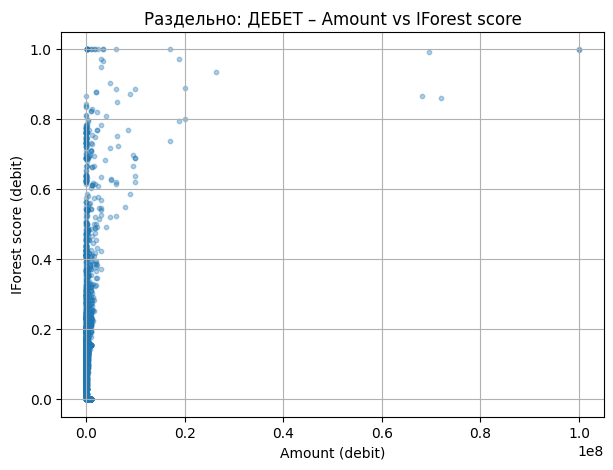

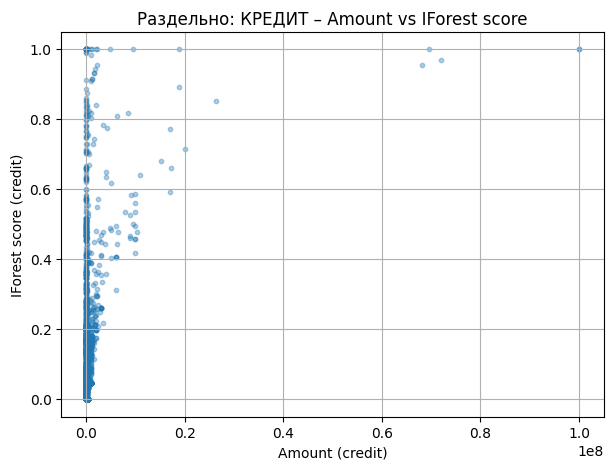

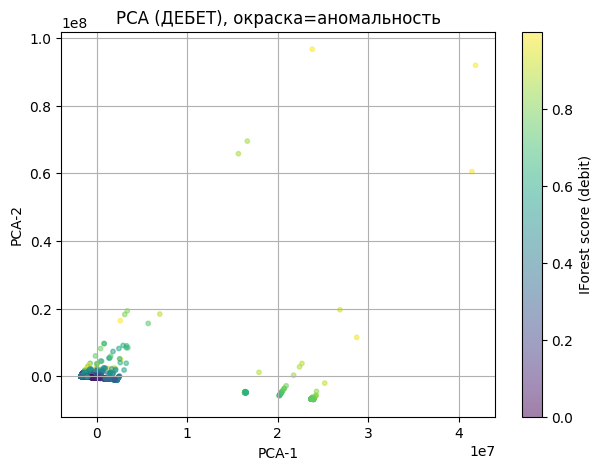

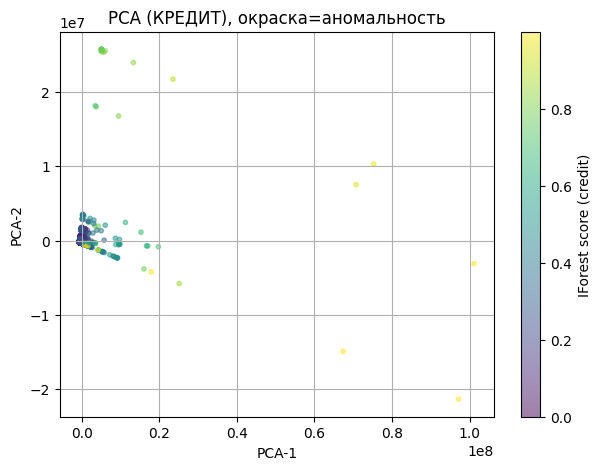

,txn_id,date,inn,side,amount,purpose,iforest_score_debit
1899,NaN,2021-07-06,8d9e0be733f77f1c,debit,100000000.0,выдача кредита по договору n600210017 от 24 ию...,1.000000
14,NaN,2019-01-15,ad57c94e5b8df8f6,debit,3400000.0,перевод денежных средств по договору займа № ч...,1.000000
493,NaN,2019-10-16,9d8f54ae3b88911b,debit,17000000.0,оплата по договору беспроцентного займа №ти-17...,1.000000
1799,NaN,2021-05-21,5ae9eeb0d29bc5c0,debit,2350000.0,перевод денежных средств по договору № пи-1/28...,1.000000
2242,NaN,2021-11-26,nan,debit,3500000.0,взнос займа по договору №34 от date_e98770c5fd...,1.000000
...,...,...,...,...,...,...,...
492,NaN,2019-10-16,d877722ca4e40f98,debit,17000000.0,оплата по счету № 20 от date_aa5e303a04cd аван...,0.738073
1953,NaN,2021-07-12,d877722ca4e40f98,debit,7705.0,оплата по счету № 6042 от 09.07.21г спецодежда...,0.736144
1952,NaN,2021-07-12,d877722ca4e40f98,debit,2790.0,оплата по договору электроэнергия по дог.№1124...,0.734545
1942,NaN,2021-07-09,d877722ca4e40f98,debit,80000.0,оплата по счету № 73 от date_63da1f80aee8 стро...,0.733509


,txn_id,date,inn,side,amount,purpose,iforest_score_credit
1898,6f0c8393c53f9de20b49f61831b09790aff6752a1f476f...,2021-07-06,8d9e0be733f77f1c,credit,1.000000e+08,формирование покрытия по внутрироссийскому акк...,1.000000
1945,f471ae9a22d722f1a8b9643208291df63eece993003757...,2021-07-09,6931e23e98703aa9,credit,6.950000e+07,окончательная оплата по счету №9 от date_aaac9...,1.000000
2508,b09bf0620a80d597edbe395cf23b36dad9e46ea6bf0d2b...,2022-08-02,1b21a7645f64d170,credit,4.869204e+06,по решению о взыскании № 5593 от date_11c36260...,1.000000
1979,c9dce093564c560801675d181a67826ffa8a8cef3c343e...,2021-07-20,80799e1a6646b6dc,credit,1.214381e+06,налог на имущество организаций за 1 квартал 20...,1.000000
1669,4db4ad205430ea684f0a5390b2f6802a73976d648d47b4...,2021-03-31,480b91025f5be8d0,credit,4.000000e+05,частичный возврат займа по договору №2-ои/1509...,1.000000
...,...,...,...,...,...,...,...
2074,0ef22d8da7dbac081bb2ce6449a36eb15d48545096120c...,2021-09-03,8d9e0be733f77f1c,credit,4.909513e+04,заработная плата по реестру №22 от date_2ee8be...,0.666410
695,970692ca3958795597972eed1f3e6fbd138b91f9d1370e...,2020-03-27,ca3891c167141f4d,credit,1.287300e+02,взносы на обязательное страхование от несчастн...,0.664769
2520,c95a7127713a4f700a6bbd227885228c535775bb1c1713...,2022-08-03,480b91025f5be8d0,credit,8.995100e+02,оплата по договору аренды кабинета по сч.№23 о...,0.661495
796,6ec5fe3dcb226b9e4288a39df644d30fc23f732d4ec8f0...,2020-06-05,035fab081fc0922f,credit,5.882120e+03,заработная плата за вторую половину мая 20г дл...,0.660684


 Сохранено: top100_anomalous_txn_debit.csv
 Сохранено: top100_anomalous_txn_credit.csv


In [29]:
# === Ячейка 2. Раздельный анализ: отдельные модели для дебета и для кредита ===
# Для каждого ИНН считаем аномалии отдельно в дебетных и отдельно в кредитных операциях.
# Фильтр: в каждой роли ИНН должен иметь >=30 транзакций по этой роли.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

RANDOM_STATE = 42
MIN_TX_PER_INN = 10

# -------- 0) Подготовка отдельных таблиц --------
# ДЕБЕТ
deb_cols = [
    "id","date","purpose","amount","debit_inn",
    "debit_roll_cnt_30d","debit_roll_mean_30d","debit_roll_std_30d",
    "debit_amount_spike_ratio_7d","debit_tx_rate_spike_7d","debit_amount_volatility_30d"
]
for c in deb_cols:
    if c not in df.columns: df[c] = 0.0 if c not in ["id","date","purpose","debit_inn"] else df.get(c, np.nan)

deb = pd.DataFrame({
    "txn_id": df["id"],
    "date": pd.to_datetime(df["date"]),
    "inn": df["debit_inn"].astype(str),
    "side": "debit",
    "purpose": df["purpose"].astype(str),
    "amount": df["amount"].astype(float),
    # фичи роли
    "roll_cnt_30d": df["debit_roll_cnt_30d"].astype(float),
    "roll_mean_30d": df["debit_roll_mean_30d"].astype(float),
    "roll_std_30d": df["debit_roll_std_30d"].astype(float),
    "amount_spike_ratio_7d": df["debit_amount_spike_ratio_7d"].astype(float),
    "tx_rate_spike_7d": df["debit_tx_rate_spike_7d"].astype(float),
    "amount_volatility_30d": df["debit_amount_volatility_30d"].astype(float),
})

# КРЕДИТ
cred_cols = [
    "id","date","purpose","amount","credit_inn",
    "credit_roll_cnt_30d","credit_roll_mean_30d","credit_roll_std_30d",
    "credit_amount_spike_ratio_7d","credit_tx_rate_spike_7d","credit_amount_volatility_30d"
]
for c in cred_cols:
    if c not in df.columns: df[c] = 0.0 if c not in ["id","date","purpose","credit_inn"] else df.get(c, np.nan)

cred = pd.DataFrame({
    "txn_id": df["txn_id"],
    "date": pd.to_datetime(df["date"]),
    "inn": df["credit_inn"].astype(str),
    "side": "credit",
    "purpose": df["purpose"].astype(str),
    "amount": df["amount"].astype(float),
    "roll_cnt_30d": df["credit_roll_cnt_30d"].astype(float),
    "roll_mean_30d": df["credit_roll_mean_30d"].astype(float),
    "roll_std_30d": df["credit_roll_std_30d"].astype(float),
    "amount_spike_ratio_7d": df["credit_amount_spike_ratio_7d"].astype(float),
    "tx_rate_spike_7d": df["credit_tx_rate_spike_7d"].astype(float),
    "amount_volatility_30d": df["credit_amount_volatility_30d"].astype(float),
})

# -------- 1) Фильтры по количеству транзакций в каждой роли --------
deb_eligible = set(deb.groupby("inn").size()[lambda s: s>=MIN_TX_PER_INN].index)
cred_eligible = set(cred.groupby("inn").size()[lambda s: s>=MIN_TX_PER_INN].index)

deb_w = deb[deb["inn"].isin(deb_eligible)].copy()
cred_w = cred[cred["inn"].isin(cred_eligible)].copy()

print(f"ИНН с >={MIN_TX_PER_INN} дебетных транзакций: {len(deb_eligible):,}")
print(f"ИНН с >={MIN_TX_PER_INN} кредитных транзакций: {len(cred_eligible):,}")
if len(deb_eligible)==0 and len(cred_eligible)==0:
    raise RuntimeError("Нет ИНН с достаточным числом транзакций ни в дебете, ни в кредите.")

# -------- 2) IsolationForest по КАЖДОЙ роли и КАЖДОМУ ИНН --------

feat_cols = [
    "amount","roll_cnt_30d","roll_mean_30d","roll_std_30d",
    "amount_spike_ratio_7d","tx_rate_spike_7d","amount_volatility_30d", "is_weekend", "is_month_end",

    
]

# оставляем первые 7 так как в PCA остальные колонки имеют 0 вес => создают шумы 
# feat_cols = [
#     # базовые суммы
#     "amount",
#     # поведенческие окна
#    "roll_cnt_30d","roll_mean_30d","roll_std_30d",
#     "amount_spike_ratio_7d","tx_rate_spike_7d","amount_volatility_30d",
#     # активность
#     "daily_debit_transaction_count", "daily_credit_transaction_count",
#     # доли в дневном объеме
#     "daily_debit_percent", "daily_credit_percent",
#     # интервалы между операциями
#     "days_since_last_txn_debit", "days_since_last_txn_credit",
#     # связи (fan-out / fan-in)
#     "debit_fan_out_ratio", "credit_fan_in_ratio",
#     # баланс вход/выход
#     "in_out_ratio_30d",
#     # округлённые суммы
#     "round_large_amount",
#     # время
#     "day_of_week", "is_weekend", "is_month_end"
# ]


for c in feat_cols:
    if c not in deb_w.columns: deb_w[c] = 0.0
    if c not in cred_w.columns: cred_w[c] = 0.0

deb_w["iforest_score_debit"] = np.nan
cred_w["iforest_score_credit"] = np.nan

iso_params = dict(n_estimators=300, contamination=0.02, random_state=RANDOM_STATE)

# Дебет
for inn in sorted(deb_eligible):
    sub = deb_w[deb_w["inn"]==inn]
    X = sub[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    iso = IsolationForest(**iso_params)
    iso.fit(Xs)
    raw = -iso.score_samples(Xs)
    s = (raw - raw.min()) / (raw.max() - raw.min() + 1e-9)
    deb_w.loc[sub.index, "iforest_score_debit"] = s

# Кредит
for inn in sorted(cred_eligible):
    sub = cred_w[cred_w["inn"]==inn]
    X = sub[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    iso = IsolationForest(**iso_params)
    iso.fit(Xs)
    raw = -iso.score_samples(Xs)
    s = (raw - raw.min()) / (raw.max() - raw.min() + 1e-9)
    cred_w.loc[sub.index, "iforest_score_credit"] = s


    

# -------- 3) Scatter-графики по ролям --------
# 3.1 Дебет: Amount vs iforest_score_debit
if len(deb_w):
    plt.figure(figsize=(7,5))
    plt.scatter(deb_w["amount"], deb_w["iforest_score_debit"], s=10, alpha=0.35)
    plt.xlabel("Amount (debit)")
    plt.ylabel("IForest score (debit)")
    plt.title("Раздельно: ДЕБЕТ – Amount vs IForest score")
    plt.grid(True)
    plt.show()

# 3.2 Кредит: Amount vs iforest_score_credit
if len(cred_w):
    plt.figure(figsize=(7,5))
    plt.scatter(cred_w["amount"], cred_w["iforest_score_credit"], s=10, alpha=0.35)
    plt.xlabel("Amount (credit)")
    plt.ylabel("IForest score (credit)")
    plt.title("Раздельно: КРЕДИТ – Amount vs IForest score")
    plt.grid(True)
    plt.show()

# (доп) PCA-проекции для каждой роли
if len(deb_w):
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    Xp = pca.fit_transform(deb_w[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values)
    plt.figure(figsize=(7,5))
    plt.scatter(Xp[:,0], Xp[:,1], c=deb_w["iforest_score_debit"], s=10, alpha=0.5)
    plt.xlabel("PCA-1"); plt.ylabel("PCA-2"); plt.title("PCA (ДЕБЕТ), окраска=аномальность")
    plt.colorbar(label="IForest score (debit)")
    plt.grid(True)
    plt.show()

if len(cred_w):
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    Xp = pca.fit_transform(cred_w[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values)
    plt.figure(figsize=(7,5))
    plt.scatter(Xp[:,0], Xp[:,1], c=cred_w["iforest_score_credit"], s=10, alpha=0.5)
    plt.xlabel("PCA-1"); plt.ylabel("PCA-2"); plt.title("PCA (КРЕДИТ), окраска=аномальность")
    plt.colorbar(label="IForest score (credit)")
    plt.grid(True)
    plt.show()

# -------- 4) Топ-100 самых подозрительных транзакций ПО ОТДЕЛЬНОСТИ --------
top100_debit = deb_w.sort_values("iforest_score_debit", ascending=False).head(100).copy()
top100_credit = cred_w.sort_values("iforest_score_credit", ascending=False).head(100).copy()

cols_out_deb = ["txn_id","date","inn","side","amount","purpose","iforest_score_debit"]
cols_out_cred = ["txn_id","date","inn","side","amount","purpose","iforest_score_credit"]

display(top100_debit[cols_out_deb])
display(top100_credit[cols_out_cred])

# Сохранение
out_deb = "top100_anomalous_txn_debit.csv"
out_cred = "top100_anomalous_txn_credit.csv"
top100_debit[cols_out_deb].to_csv(out_deb, index=False, encoding="utf-8-sig")
top100_credit[cols_out_cred].to_csv(out_cred, index=False, encoding="utf-8-sig")
print(f" Сохранено: {out_deb}")
print(f" Сохранено: {out_cred}")

# Подсчет индивидуальных аномалий по дебету и кредиту
debit_individual_scores = deb_w.sort_values("iforest_score_debit", ascending=False).copy()
credit_individual_scores = cred_w.sort_values("iforest_score_credit", ascending=False).copy()

ИНН с >=10 транзакций ИТОГО: 37
  └ прошли в ДЕБЕТ (>= 10 по дебету): 10
  └ прошли в КРЕДИТ (>= 10 по кредиту): 27


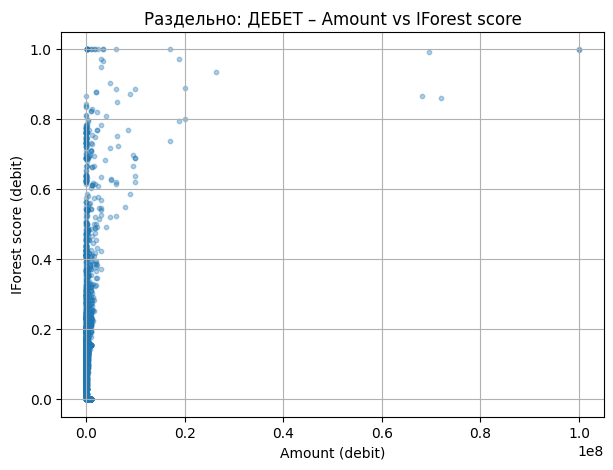

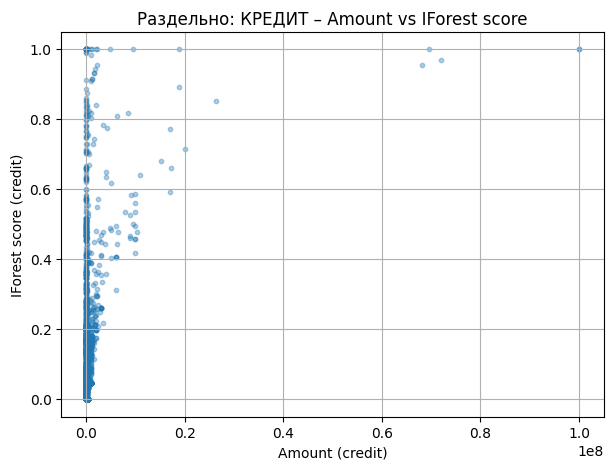

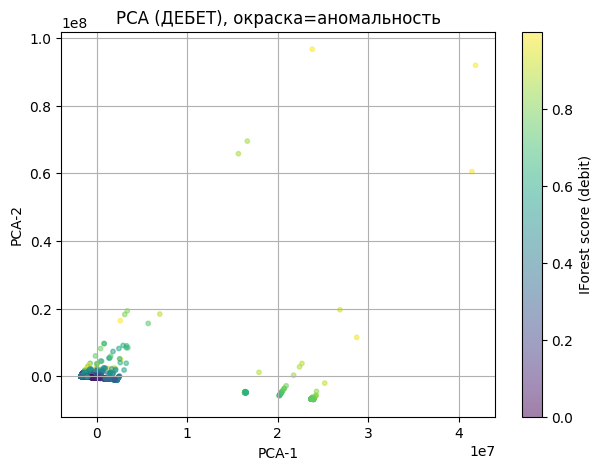

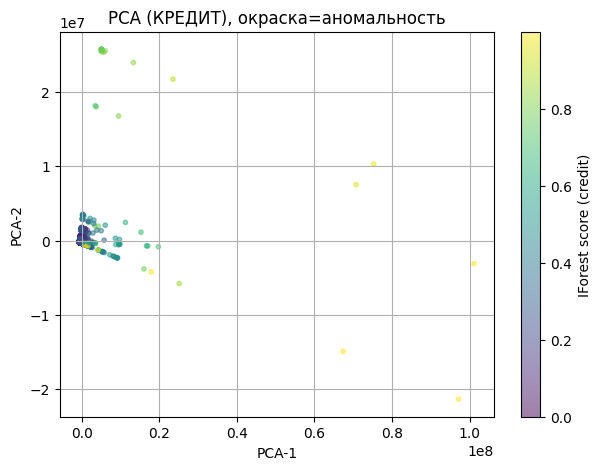

,txn_id,date,inn,side,amount,purpose,iforest_score_debit
1899,fe4aac925c29eb5ee3884ea411b3ca4cfbe392e34a20af...,2021-07-06,8d9e0be733f77f1c,debit,100000000.0,выдача кредита по договору n600210017 от 24 ию...,1.000000
14,a914c41a13ec94ad2efd292d7838e5e5e237989bc7b696...,2019-01-15,ad57c94e5b8df8f6,debit,3400000.0,перевод денежных средств по договору займа № ч...,1.000000
493,e93b01567cd958e16c3c073115e2d002d1c9e68b55d5be...,2019-10-16,9d8f54ae3b88911b,debit,17000000.0,оплата по договору беспроцентного займа №ти-17...,1.000000
1799,6f692936c4d37e911bb4758e9c67fadc3ac4d12a11619e...,2021-05-21,5ae9eeb0d29bc5c0,debit,2350000.0,перевод денежных средств по договору № пи-1/28...,1.000000
2242,e7cbd15795c5bbd3c0d1d68b62dbf8d60fa24834f95209...,2021-11-26,nan,debit,3500000.0,взнос займа по договору №34 от date_e98770c5fd...,1.000000
...,...,...,...,...,...,...,...
492,514edb987243916c404c952a36e0bff3720cc94a365552...,2019-10-16,d877722ca4e40f98,debit,17000000.0,оплата по счету № 20 от date_aa5e303a04cd аван...,0.738073
1953,bc82b98a30f7e8ec503ba14271c5302feb06b5287b7bff...,2021-07-12,d877722ca4e40f98,debit,7705.0,оплата по счету № 6042 от 09.07.21г спецодежда...,0.736144
1952,a90515e1dd90a01cae1a1f6e07c1fe903a3d456d70af3d...,2021-07-12,d877722ca4e40f98,debit,2790.0,оплата по договору электроэнергия по дог.№1124...,0.734545
1942,fb64628ed52f0bb3c030451ec6fb9f4081baaf92f5ed64...,2021-07-09,d877722ca4e40f98,debit,80000.0,оплата по счету № 73 от date_63da1f80aee8 стро...,0.733509


,txn_id,date,inn,side,amount,purpose,iforest_score_credit
1898,6f0c8393c53f9de20b49f61831b09790aff6752a1f476f...,2021-07-06,8d9e0be733f77f1c,credit,1.000000e+08,формирование покрытия по внутрироссийскому акк...,1.000000
1945,f471ae9a22d722f1a8b9643208291df63eece993003757...,2021-07-09,6931e23e98703aa9,credit,6.950000e+07,окончательная оплата по счету №9 от date_aaac9...,1.000000
2508,b09bf0620a80d597edbe395cf23b36dad9e46ea6bf0d2b...,2022-08-02,1b21a7645f64d170,credit,4.869204e+06,по решению о взыскании № 5593 от date_11c36260...,1.000000
1979,c9dce093564c560801675d181a67826ffa8a8cef3c343e...,2021-07-20,80799e1a6646b6dc,credit,1.214381e+06,налог на имущество организаций за 1 квартал 20...,1.000000
1669,4db4ad205430ea684f0a5390b2f6802a73976d648d47b4...,2021-03-31,480b91025f5be8d0,credit,4.000000e+05,частичный возврат займа по договору №2-ои/1509...,1.000000
...,...,...,...,...,...,...,...
2074,0ef22d8da7dbac081bb2ce6449a36eb15d48545096120c...,2021-09-03,8d9e0be733f77f1c,credit,4.909513e+04,заработная плата по реестру №22 от date_2ee8be...,0.666410
695,970692ca3958795597972eed1f3e6fbd138b91f9d1370e...,2020-03-27,ca3891c167141f4d,credit,1.287300e+02,взносы на обязательное страхование от несчастн...,0.664769
2520,c95a7127713a4f700a6bbd227885228c535775bb1c1713...,2022-08-03,480b91025f5be8d0,credit,8.995100e+02,оплата по договору аренды кабинета по сч.№23 о...,0.661495
796,6ec5fe3dcb226b9e4288a39df644d30fc23f732d4ec8f0...,2020-06-05,035fab081fc0922f,credit,5.882120e+03,заработная плата за вторую половину мая 20г дл...,0.660684


 Сохранено: top100_anomalous_txn_debit.csv
 Сохранено: top100_anomalous_txn_credit.csv
 Сохранено: eligible_inn_summary.csv


In [30]:
# === Ячейка 2. Раздельный анализ: отдельные модели для дебета и для кредита ===
# Для каждого ИНН считаем аномалии отдельно в дебетных и отдельно в кредитных операциях.
# Фильтр: ИНН должен иметь >=10 транзакций ИТОГО (debit+credit) и >=10 транзакций в своей роли.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

RANDOM_STATE = 42
MIN_TX_PER_INN = 10

# -------- 0) Подготовка отдельных таблиц --------
# ДЕБЕТ
deb_cols = [
    "txn_id","date","purpose","amount","debit_inn",
    "debit_roll_cnt_30d","debit_roll_mean_30d","debit_roll_std_30d",
    "debit_amount_spike_ratio_7d","debit_tx_rate_spike_7d","debit_amount_volatility_30d"
]
for c in deb_cols:
    if c not in df.columns:
        df[c] = 0.0 if c not in ["id","date","purpose","debit_inn"] else df.get(c, np.nan)

deb = pd.DataFrame({
    "txn_id": df["txn_id"],
    "date": pd.to_datetime(df["date"]),
    "inn": df["debit_inn"].astype(str),
    "side": "debit",
    "purpose": df["purpose"].astype(str),
    "amount": df["amount"].astype(float),
    # фичи роли
    "roll_cnt_30d": df["debit_roll_cnt_30d"].astype(float),
    "roll_mean_30d": df["debit_roll_mean_30d"].astype(float),
    "roll_std_30d": df["debit_roll_std_30d"].astype(float),
    "amount_spike_ratio_7d": df["debit_amount_spike_ratio_7d"].astype(float),
    "tx_rate_spike_7d": df["debit_tx_rate_spike_7d"].astype(float),
    "amount_volatility_30d": df["debit_amount_volatility_30d"].astype(float),
})

# КРЕДИТ
cred_cols = [
    "txn_id","date","purpose","amount","credit_inn",
    "credit_roll_cnt_30d","credit_roll_mean_30d","credit_roll_std_30d",
    "credit_amount_spike_ratio_7d","credit_tx_rate_spike_7d","credit_amount_volatility_30d"
]
for c in cred_cols:
    if c not in df.columns:
        df[c] = 0.0 if c not in ["id","date","purpose","credit_inn"] else df.get(c, np.nan)

cred = pd.DataFrame({
    "txn_id": df["txn_id"],
    "date": pd.to_datetime(df["date"]),
    "inn": df["credit_inn"].astype(str),
    "side": "credit",
    "purpose": df["purpose"].astype(str),
    "amount": df["amount"].astype(float),
    "roll_cnt_30d": df["credit_roll_cnt_30d"].astype(float),
    "roll_mean_30d": df["credit_roll_mean_30d"].astype(float),
    "roll_std_30d": df["credit_roll_std_30d"].astype(float),
    "amount_spike_ratio_7d": df["credit_amount_spike_ratio_7d"].astype(float),
    "tx_rate_spike_7d": df["credit_tx_rate_spike_7d"].astype(float),
    "amount_volatility_30d": df["credit_amount_volatility_30d"].astype(float),
})

# -------- 1) Фильтры по количеству транзакций --------
# Подсчёты по ролям
counts_deb = deb.groupby("inn").size()
counts_cred = cred.groupby("inn").size()

# Итоговый счётчик по ИНН (debit + credit)
total_counts = counts_deb.add(counts_cred, fill_value=0).astype(int)
total_eligible = set(total_counts[total_counts >= MIN_TX_PER_INN].index)

# Ролевые пороги: в этой роли тоже должно быть >= MIN_TX_PER_INN
deb_role_eligible = set(counts_deb[counts_deb >= MIN_TX_PER_INN].index)
cred_role_eligible = set(counts_cred[counts_cred >= MIN_TX_PER_INN].index)

# Итоговая выборка: только ИНН, прошедшие общий порог И Имеющие нужный объём по роли
deb_eligible = total_eligible & deb_role_eligible
cred_eligible = total_eligible & cred_role_eligible

deb_w = deb[deb["inn"].isin(deb_eligible)].copy()
cred_w = cred[cred["inn"].isin(cred_eligible)].copy()

print(f"ИНН с >={MIN_TX_PER_INN} транзакций ИТОГО: {len(total_eligible):,}")
print(f"  └ прошли в ДЕБЕТ (>= {MIN_TX_PER_INN} по дебету): {len(deb_eligible):,}")
print(f"  └ прошли в КРЕДИТ (>= {MIN_TX_PER_INN} по кредиту): {len(cred_eligible):,}")
if len(deb_eligible)==0 and len(cred_eligible)==0:
    raise RuntimeError("Нет ИНН, удовлетворяющих порогу по общему числу и по роли (ни в дебете, ни в кредите).")

# -------- 2) IsolationForest по КАЖДОЙ роли и КАЖДОМУ ИНН --------
feat_cols = [
    "amount","roll_cnt_30d","roll_mean_30d","roll_std_30d",
    "amount_spike_ratio_7d","tx_rate_spike_7d","amount_volatility_30d",
    "is_weekend","is_month_end",
]
# Подстрахуем отсутствие некоторых фичей
for c in feat_cols:
    if c not in deb_w.columns: deb_w[c] = 0.0
    if c not in cred_w.columns: cred_w[c] = 0.0

deb_w["iforest_score_debit"] = np.nan
cred_w["iforest_score_credit"] = np.nan

iso_params = dict(n_estimators=300, contamination=0.02, random_state=RANDOM_STATE)

# ДЕБЕТ
for inn in sorted(deb_eligible):
    sub = deb_w[deb_w["inn"] == inn]
    X = sub[feat_cols].replace([np.inf, -np.inf], 0.0).fillna(0.0).values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    iso = IsolationForest(**iso_params)
    iso.fit(Xs)
    raw = -iso.score_samples(Xs)
    s = (raw - raw.min()) / (raw.max() - raw.min() + 1e-9)
    deb_w.loc[sub.index, "iforest_score_debit"] = s

# КРЕДИТ
for inn in sorted(cred_eligible):
    sub = cred_w[cred_w["inn"] == inn]
    X = sub[feat_cols].replace([np.inf, -np.inf], 0.0).fillna(0.0).values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    iso = IsolationForest(**iso_params)
    iso.fit(Xs)
    raw = -iso.score_samples(Xs)
    s = (raw - raw.min()) / (raw.max() - raw.min() + 1e-9)
    cred_w.loc[sub.index, "iforest_score_credit"] = s

# -------- 3) Scatter-графики по ролям --------
# 3.1 ДЕБЕТ: Amount vs iforest_score_debit
if len(deb_w):
    plt.figure(figsize=(7,5))
    plt.scatter(deb_w["amount"], deb_w["iforest_score_debit"], s=10, alpha=0.35)
    plt.xlabel("Amount (debit)")
    plt.ylabel("IForest score (debit)")
    plt.title("Раздельно: ДЕБЕТ – Amount vs IForest score")
    plt.grid(True)
    plt.show()

# 3.2 КРЕДИТ: Amount vs iforest_score_credit
if len(cred_w):
    plt.figure(figsize=(7,5))
    plt.scatter(cred_w["amount"], cred_w["iforest_score_credit"], s=10, alpha=0.35)
    plt.xlabel("Amount (credit)")
    plt.ylabel("IForest score (credit)")
    plt.title("Раздельно: КРЕДИТ – Amount vs IForest score")
    plt.grid(True)
    plt.show()

# (доп) PCA-проекции для каждой роли
if len(deb_w) >= 3:
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    Xp = pca.fit_transform(deb_w[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values)
    plt.figure(figsize=(7,5))
    plt.scatter(Xp[:,0], Xp[:,1], c=deb_w["iforest_score_debit"], s=10, alpha=0.5)
    plt.xlabel("PCA-1"); plt.ylabel("PCA-2"); plt.title("PCA (ДЕБЕТ), окраска=аномальность")
    plt.colorbar(label="IForest score (debit)")
    plt.grid(True)
    plt.show()

if len(cred_w) >= 3:
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    Xp = pca.fit_transform(cred_w[feat_cols].replace([np.inf,-np.inf],0.0).fillna(0.0).values)
    plt.figure(figsize=(7,5))
    plt.scatter(Xp[:,0], Xp[:,1], c=cred_w["iforest_score_credit"], s=10, alpha=0.5)
    plt.xlabel("PCA-1"); plt.ylabel("PCA-2"); plt.title("PCA (КРЕДИТ), окраска=аномальность")
    plt.colorbar(label="IForest score (credit)")
    plt.grid(True)
    plt.show()

# -------- 4) Топ-100 самых подозрительных транзакций ПО ОТДЕЛЬНОСТИ --------
# В выборках уже только ИНН, прошедшие общий и ролевой пороги
top100_debit = deb_w.sort_values("iforest_score_debit", ascending=False).head(100).copy()
top100_credit = cred_w.sort_values("iforest_score_credit", ascending=False).head(100).copy()

cols_out_deb = ["txn_id","date","inn","side","amount","purpose","iforest_score_debit"]
cols_out_cred = ["txn_id","date","inn","side","amount","purpose","iforest_score_credit"]

display(top100_debit[cols_out_deb])
display(top100_credit[cols_out_cred])

# Сохранение: только по ИНН, удовлетворяющим порогам
out_deb = "top100_anomalous_txn_debit.csv"
out_cred = "top100_anomalous_txn_credit.csv"
top100_debit[cols_out_deb].to_csv(out_deb, index=False, encoding="utf-8-sig")
top100_credit[cols_out_cred].to_csv(out_cred, index=False, encoding="utf-8-sig")
print(f" Сохранено: {out_deb}")
print(f" Сохранено: {out_cred}")

# (опционально) Сохранить перечень ИНН, прошедших общий порог и ролевые пороги
eligible_summary = pd.DataFrame({
    "inn": sorted(total_eligible),
    "total_txn": [int(total_counts.get(i, 0)) for i in sorted(total_eligible)],
    "eligible_in_debit": [i in deb_eligible for i in sorted(total_eligible)],
    "eligible_in_credit": [i in cred_eligible for i in sorted(total_eligible)],
})
eligible_summary.to_csv("eligible_inn_summary.csv", index=False, encoding="utf-8-sig")
print(" Сохранено: eligible_inn_summary.csv")

# Подсчет индивидуальных аномалий по дебету и кредиту (только по отфильтрованным ИНН)
debit_individual_scores = deb_w.sort_values("iforest_score_debit", ascending=False).copy()
credit_individual_scores = cred_w.sort_values("iforest_score_credit", ascending=False).copy()


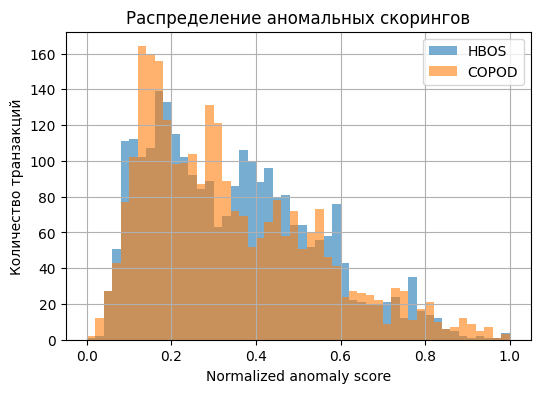

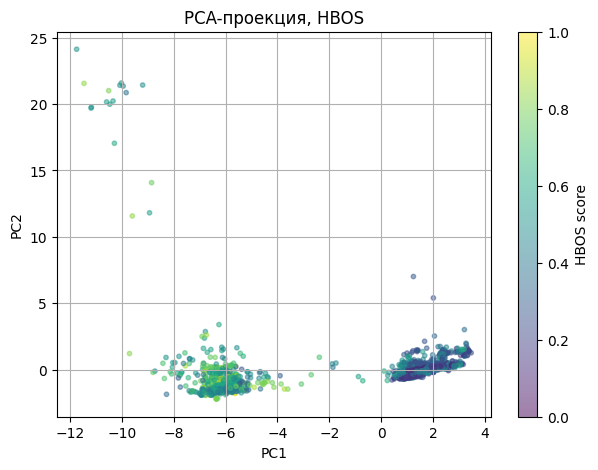

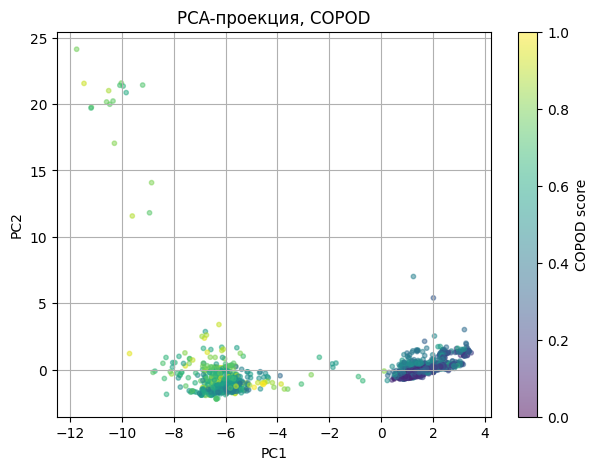

 Сохранено: top100_hbos_tfidf.csv, top100_copod_tfidf.csv
Топ-10 наиболее информативных признаков по PCA:
                                PCA_importance
credit_roll_std_30d                   0.646799
in_out_ratio_30d                      0.640984
credit_roll_mean_30d                  0.639870
credit_fan_in_ratio                   0.346314
daily_credit_transaction_count        0.331952
debit_fan_out_ratio                   0.330255
credit_roll_cnt_30d                   0.310874
credit_tx_rate_spike_7d               0.305851
credit_amount_volatility_30d          0.286589
debit_amount_volatility_30d           0.282102


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# если PyOD не установлен: pip install pyod
from pyod.models.hbos import HBOS
from pyod.models.copod import COPOD


feat_cols = [
    # базовая сумма
    "amount",

    # поведенческие окна: дебет
    "debit_roll_cnt_30d", "debit_roll_mean_30d", "debit_roll_std_30d",
    "debit_amount_spike_ratio_7d", "debit_tx_rate_spike_7d", "debit_amount_volatility_30d",

    # поведенческие окна: кредит
    "credit_roll_cnt_30d", "credit_roll_mean_30d", "credit_roll_std_30d",
    "credit_amount_spike_ratio_7d", "credit_tx_rate_spike_7d", "credit_amount_volatility_30d",

    # активность за день
    "daily_debit_transaction_count", "daily_credit_transaction_count",

    # доля текущей операции в суточном объёме
    "daily_debit_percent", "daily_credit_percent",

    # интервалы между операциями (в днях)
    "days_since_last_txn_debit", "days_since_last_txn_credit",

    # fan-out / fan-in
    "debit_fan_out_ratio", "credit_fan_in_ratio",

    # дисбаланс потоков
    "in_out_ratio_30d",

    # округлённые суммы
    "round_large_amount",

    # время
    "day_of_week", "is_weekend", "is_month_end",

    "purpose_stopword_high",
    
    
] + [f"purpose_svd_{i}" for i in range(1,51)]

RANDOM_STATE = 42

# --- 1) Подготовка данных ---
X = df[feat_cols].replace([np.inf, -np.inf], 0).fillna(0.0)
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# --- 2) HBOS ---
hbos = HBOS(contamination=0.02)     # 2 % аномалий по умолчанию
hbos.fit(Xs)
score_hbos = hbos.decision_function(Xs)   # чем выше — аномальнее
score_hbos = (score_hbos - score_hbos.min()) / (score_hbos.max() - score_hbos.min() + 1e-9)
df["hbos_score"] = score_hbos

# --- 3) COPOD ---
copod = COPOD(contamination=0.02)
copod.fit(Xs)
score_copod = copod.decision_function(Xs)
score_copod = (score_copod - score_copod.min()) / (score_copod.max() - score_copod.min() + 1e-9)
df["copod_score"] = score_copod

# --- 4) Визуализация распределений ---
plt.figure(figsize=(6,4))
plt.hist(df["hbos_score"], bins=50, alpha=0.6, label="HBOS")
plt.hist(df["copod_score"], bins=50, alpha=0.6, label="COPOD")
plt.legend(); plt.title("Распределение аномальных скорингов")
plt.xlabel("Normalized anomaly score"); plt.ylabel("Количество транзакций")
plt.grid(True); plt.show()

# --- 5) PCA для 2D-проекции ---
pca = PCA(n_components=2, random_state=RANDOM_STATE)
Xp = pca.fit_transform(Xs)

plt.figure(figsize=(7,5))
plt.scatter(Xp[:,0], Xp[:,1], c=df["hbos_score"], s=10, alpha=0.5)
plt.colorbar(label="HBOS score"); plt.title("PCA-проекция, HBOS")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.grid(True); plt.show()

plt.figure(figsize=(7,5))
plt.scatter(Xp[:,0], Xp[:,1], c=df["copod_score"], s=10, alpha=0.5)
plt.colorbar(label="COPOD score"); plt.title("PCA-проекция, COPOD")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.grid(True); plt.show()

# --- 6) Топ-100 подозрительных транзакций ---
top100_hbos = df.sort_values("hbos_score", ascending=False).head(2000)
top100_copod = df.sort_values("copod_score", ascending=False).head(2000)

cols_out = ["date","debit_inn","credit_inn","amount","purpose","hbos_score","copod_score"]
top100_hbos[cols_out].to_csv("top100_hbos_tfidf.csv", index=False, encoding="utf-8-sig")
top100_copod[cols_out].to_csv("top100_copod_tfidf.csv", index=False, encoding="utf-8-sig")

print(" Сохранено: top100_hbos_tfidf.csv, top100_copod_tfidf.csv")

# --- 7) Полезность признаков (через PCA-нагрузки) ---
loadings = pd.DataFrame(
    np.abs(pca.components_).sum(axis=0),
    index=feat_cols,
    columns=["PCA_importance"]
).sort_values("PCA_importance", ascending=False)
print("Топ-10 наиболее информативных признаков по PCA:")
print(loadings.head(10))

full_anomaly_scores = top100_copod = df.sort_values("copod_score", ascending=False).copy()


In [32]:
full_anomaly_scores.head()

,date,debit_account,debit_name,debit_inn,credit_account,credit_name,credit_inn,debit_amount,credit_amount,purpose,...,purpose_svd_44,purpose_svd_45,purpose_svd_46,purpose_svd_47,purpose_svd_48,purpose_svd_49,purpose_svd_50,id,hbos_score,copod_score
2680,2024-12-03,15906017a4dc3770,b736fcdbf591b1c2,d877722ca4e40f98,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,0.0,1000.0,перевод средств между счетами сумма 1000-00 бе...,...,-0.001918,-0.067267,-0.012746,-0.017781,-0.012838,0.002147,-0.008490,NaN,0.802540,1.000000
2677,2024-07-05,15906017a4dc3770,b736fcdbf591b1c2,d877722ca4e40f98,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,0.0,3000.0,перевод средств между счетами сумма 3000-00 бе...,...,-0.002318,-0.023801,0.002935,0.035187,0.010035,-0.001930,-0.002632,NaN,0.812622,0.994094
2643,2023-06-13,15906017a4dc3770,b736fcdbf591b1c2,d877722ca4e40f98,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,0.0,30000.0,перевод средств между счетами сумма 30000-00 б...,...,-0.000968,-0.023683,-0.002240,0.046600,0.013092,0.008767,-0.007868,NaN,0.867303,0.990788
2604,2022-12-14,15906017a4dc3770,b736fcdbf591b1c2,d877722ca4e40f98,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,0.0,1500.0,перевод средств между счетами сумма 1500-00 бе...,...,0.005471,-0.030466,0.009324,-0.044786,-0.003533,-0.014684,-0.010172,NaN,0.816772,0.972838
509,2019-10-31,ebf9da38fce38ef6,3ecb151b6a80269e,89e588b9010869a4,ded93f97f389bf2c,1d7e02da93438ace,d877722ca4e40f98,0.0,300000.0,оплата по договор_aa2bdccd4f22 беспроцентного ...,...,-0.043231,0.328833,-0.191275,0.218299,0.004972,-0.100326,-0.007278,NaN,0.884527,0.958703


In [33]:
len(full_anomaly_scores)

2688

In [34]:
node_scores.head()

,participation,edge_based_score,isolation_score,node_score
inn,,,,
a1294270cfe6533d,1,0.796470,1.227244,1.011857
d165cf0df41bf2b8,1,0.927335,1.091201,1.009268
385844c16cc4dcb1,1,0.732666,1.197640,0.965153
b7cc789e957991dc,1,0.689116,1.174719,0.931917
086628377cd0ba48,1,0.626217,1.164523,0.895370


In [35]:
len(node_scores)

111

In [36]:
debit_individual_scores.head()

,txn_id,date,inn,side,purpose,amount,roll_cnt_30d,roll_mean_30d,roll_std_30d,amount_spike_ratio_7d,tx_rate_spike_7d,amount_volatility_30d,is_weekend,is_month_end,iforest_score_debit
1899,fe4aac925c29eb5ee3884ea411b3ca4cfbe392e34a20af...,2021-07-06,8d9e0be733f77f1c,debit,выдача кредита по договору n600210017 от 24 ию...,100000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14,a914c41a13ec94ad2efd292d7838e5e5e237989bc7b696...,2019-01-15,ad57c94e5b8df8f6,debit,перевод денежных средств по договору займа № ч...,3400000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
493,e93b01567cd958e16c3c073115e2d002d1c9e68b55d5be...,2019-10-16,9d8f54ae3b88911b,debit,оплата по договору беспроцентного займа №ти-17...,17000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1799,6f692936c4d37e911bb4758e9c67fadc3ac4d12a11619e...,2021-05-21,5ae9eeb0d29bc5c0,debit,перевод денежных средств по договору № пи-1/28...,2350000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2242,e7cbd15795c5bbd3c0d1d68b62dbf8d60fa24834f95209...,2021-11-26,nan,debit,взнос займа по договору №34 от date_e98770c5fd...,3500000.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0


In [37]:
len(debit_individual_scores)

2604

In [38]:
debit_individual_scores.tail()

,txn_id,date,inn,side,purpose,amount,roll_cnt_30d,roll_mean_30d,roll_std_30d,amount_spike_ratio_7d,tx_rate_spike_7d,amount_volatility_30d,is_weekend,is_month_end,iforest_score_debit
220,24b9b7a948a37ca3eb218d43720fd11085e4e8feedcf03...,2019-06-28,6ef5667d7851dcbc,debit,перевод денежных средств по договору № ли-2/06...,1000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1299,676e0e7b0e4f6bf25e564958926615bbf3b119a34a7f23...,2020-12-04,9d8f54ae3b88911b,debit,оплата по договору беспроцентного займа №ти-21...,30000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
249,d5441b94baa8776bad842d08ac951b14fb5eed21f51a9c...,2019-07-12,6ef5667d7851dcbc,debit,перевод денежных средств по договору № ли-2/06...,1000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
252,08ce01b992d1d9f9b2633de09a7f01d09f4e4ee4ed3c56...,2019-07-15,6ef5667d7851dcbc,debit,перевод денежных средств по договору № ли-2/06...,1000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2280,56bf981fb3b95f4960c2494b345207894000541292ea9b...,2021-12-20,nan,debit,оплата по договору займа 34 от 01.10.21 за зай...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [39]:
credit_individual_scores.head()

,txn_id,date,inn,side,purpose,amount,roll_cnt_30d,roll_mean_30d,roll_std_30d,amount_spike_ratio_7d,tx_rate_spike_7d,amount_volatility_30d,is_weekend,is_month_end,iforest_score_credit
1898,6f0c8393c53f9de20b49f61831b09790aff6752a1f476f...,2021-07-06,8d9e0be733f77f1c,credit,формирование покрытия по внутрироссийскому акк...,1.000000e+08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1945,f471ae9a22d722f1a8b9643208291df63eece993003757...,2021-07-09,6931e23e98703aa9,credit,окончательная оплата по счету №9 от date_aaac9...,6.950000e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2508,b09bf0620a80d597edbe395cf23b36dad9e46ea6bf0d2b...,2022-08-02,1b21a7645f64d170,credit,по решению о взыскании № 5593 от date_11c36260...,4.869204e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1979,c9dce093564c560801675d181a67826ffa8a8cef3c343e...,2021-07-20,80799e1a6646b6dc,credit,налог на имущество организаций за 1 квартал 20...,1.214381e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1669,4db4ad205430ea684f0a5390b2f6802a73976d648d47b4...,2021-03-31,480b91025f5be8d0,credit,частичный возврат займа по договору №2-ои/1509...,4.000000e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [40]:
credit_individual_scores.tail()

,txn_id,date,inn,side,purpose,amount,roll_cnt_30d,roll_mean_30d,roll_std_30d,amount_spike_ratio_7d,tx_rate_spike_7d,amount_volatility_30d,is_weekend,is_month_end,iforest_score_credit
1680,b3f26248e4fc7e71123f7abc91e67d11e51d65c62616f0...,2021-04-05,8d9e0be733f77f1c,credit,комиссия в другие банки (кредитные организации...,37.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1065,31b56d5ee5143ed234e32402eb0949b6c3ad6ef95973d2...,2020-09-14,6931e23e98703aa9,credit,оплата по счету № 6 от date_83efb0c10d24 утепл...,500000.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2202,c3152126563446afe409db9e277f18a28c0a1038556693...,2021-11-11,cf603eadad6f36c6,credit,оплата по с/ф юс006848 от 31.10.21г за октябрь...,5438.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2200,9468c42aa142fb83150b4959cdd8aaa557c6e759b1a717...,2021-11-11,a4bb2adbd377d7b6,credit,оплата по счету №3255 от 31.10.21 тревожной си...,602.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1098,42b9231e1a003fe11b00773ba5c4049bc6baaee59ae0db...,2020-09-28,8d9e0be733f77f1c,credit,комиссия в другие банки (кредитные организации...,37.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
len(credit_individual_scores)

2502

In [42]:
# === Ячейка N. Итоговая интеграция: доверие к индивидуальной модели и общий риск ===
import numpy as np
import pandas as pd

# 0) Глобальный скор из второй ячейки (HBOS/COPOD) — ожидается уже в df
if "hbos_score" not in df.columns or "copod_score" not in df.columns:
    print("Ожидаются колонки hbos_score и copod_score из второй ячейки.")
df["global_score"] = (df["hbos_score"].fillna(0) + df["copod_score"].fillna(0)) / 2.0
df["global_score"] = df["global_score"].clip(0, 1)

# 1) Подтянем индивидуальные скоринги IsolationForest из первой ячейки
#    (deb_w/cred_w там есть; если нет — объединим из df по txn_id)
def _safe_merge_score(base_df, side_df, side_col, score_col):
    if side_df is None or score_col not in side_df.columns:
        # попробуем вытащить из текущего df, если уже есть эти колонки
        if score_col in base_df.columns:
            return base_df[score_col]
        else:
            return pd.Series(np.nan, index=base_df.index)
    m = base_df[["txn_id"]].merge(
        side_df[["txn_id", score_col]],
        left_on="txn_id", right_on="txn_id", how="left"
    )
    return m[score_col].reindex(base_df.index).values

try:
    deb_scores_series = _safe_merge_score(df, deb_w, "debit", "iforest_score_debit")
except NameError:
    deb_scores_series = pd.Series(np.nan, index=df.index)

try:
    cred_scores_series = _safe_merge_score(df, cred_w, "credit", "iforest_score_credit")
except NameError:
    cred_scores_series = pd.Series(np.nan, index=df.index)

df["iforest_score_debit"]  = pd.Series(deb_scores_series, index=df.index)
df["iforest_score_credit"] = pd.Series(cred_scores_series, index=df.index)

# 2) Размеры групп (объём историй у ИНН) — влияют на доверие к индивидуальной модели
counts_deb  = df.groupby("debit_inn").size()
counts_cred = df.groupby("credit_inn").size()
n_deb  = df["debit_inn"].map(counts_deb).fillna(0).astype(int)
n_cred = df["credit_inn"].map(counts_cred).fillna(0).astype(int)

# робастные максимумы для нормализации лог-скейла
max_n_deb  = max(int(counts_deb.max()) if len(counts_deb) else 1, MIN_TX_PER_INN)
max_n_cred = max(int(counts_cred.max()) if len(counts_cred) else 1, MIN_TX_PER_INN)

# 3) Доверие (alpha) к индивидуальной модели по твоей формуле (с клипом)
#    alpha растёт с числом транзакций ИНН в соответствующей роли
alpha_deb  = (0.35 + 0.5 * np.log1p(n_deb)  / np.log1p(max_n_deb)).clip(0.35, 0.85)
alpha_cred = (0.35 + 0.5 * np.log1p(n_cred) / np.log1p(max_n_cred)).clip(0.35, 0.85)

# где индивидуального скора нет — ставим 0 веса на индивидуальный (как в твоём примере)
alpha_deb  = np.where(pd.notna(df["iforest_score_debit"]),  alpha_deb,  0.0)
alpha_cred = np.where(pd.notna(df["iforest_score_credit"]), alpha_cred, 0.0)

df["alpha_debit"]  = alpha_deb
df["alpha_credit"] = alpha_cred

# 4) Бленды по ролям: individual vs global
blend_deb  = alpha_deb  * df["iforest_score_debit"].fillna(0)  + (1 - alpha_deb)  * df["global_score"]
blend_cred = alpha_cred * df["iforest_score_credit"].fillna(0) + (1 - alpha_cred) * df["global_score"]

df["txn_risk_debit"]  = pd.Series(blend_deb,  index=df.index).clip(0, 1)
df["txn_risk_credit"] = pd.Series(blend_cred, index=df.index).clip(0, 1)

# 5) Итоговый риск транзакции:
#    если есть обе роли — берём максимум (пессимистично); если одна — берём её; если ни одной — global_score
both = pd.notna(df["iforest_score_debit"]) | pd.notna(df["iforest_score_credit"])
df["txn_risk_score"] = np.where(
    both,
    np.maximum(df["txn_risk_debit"], df["txn_risk_credit"]),
    df["global_score"]
).clip(0, 1)

# 6) Сохранение топ-100 итоговых
cols_out = [
    "date","debit_inn","credit_inn","amount","purpose",
    "hbos_score","copod_score","global_score",
    "iforest_score_debit","iforest_score_credit",
    "alpha_debit","alpha_credit",
    "txn_risk_debit","txn_risk_credit","txn_risk_score"
]
top100_final = df.sort_values("txn_risk_score", ascending=False).copy()
top100_final[cols_out].to_csv("top100_txn_final_blend.csv", index=False, encoding="utf-8-sig")
print(" Сохранено: top100_txn_final_blend.csv")


 Сохранено: top100_txn_final_blend.csv


In [43]:
df.head()

,date,debit_account,debit_name,debit_inn,credit_account,credit_name,credit_inn,debit_amount,credit_amount,purpose,...,hbos_score,copod_score,global_score,iforest_score_debit,iforest_score_credit,alpha_debit,alpha_credit,txn_risk_debit,txn_risk_credit,txn_risk_score
0,2019-01-09,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,0c00203649ed677a,e19cc80da09f445f,8d9e0be733f77f1c,10.0,0.0,комиссия внутри сбербанка за пп/пт через дбо с...,...,0.235917,0.350214,0.293065,0.865975,0.016073,0.85000,0.850000,0.780039,0.057622,0.780039
1,2019-01-09,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,7682fd5c32e028f5,796a88c244ffcc0a,6931e23e98703aa9,3000000.0,0.0,оплата по счету № 28 от date_9f241b636025 по д...,...,0.317253,0.330031,0.323642,0.971760,0.259830,0.85000,0.752596,0.874543,0.275618,0.874543
2,2019-01-10,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,0c00203649ed677a,e19cc80da09f445f,8d9e0be733f77f1c,10.0,0.0,комиссия внутри сбербанка за пп/пт через дбо с...,...,0.105861,0.255485,0.180673,0.810107,0.016073,0.85000,0.850000,0.715692,0.040763,0.715692
3,2019-01-10,ded93f97f389bf2c,b736fcdbf591b1c2,d877722ca4e40f98,e63cf19b76230a3d,21a73421ca00ae87,eed8b1f54ed4366c,4282.0,0.0,оплата по договору электроэнергия по дог.№1124...,...,0.411124,0.438177,0.424651,0.812001,0.033687,0.85000,0.670595,0.753899,0.162473,0.753899
4,2019-01-10,d658b4e51c5a5df5,f7185cc66db08da5,ad57c94e5b8df8f6,ded93f97f389bf2c,3e368a63959d285e,d877722ca4e40f98,0.0,1000000.0,перевод денежных средств по договору займа № ч...,...,0.566143,0.586387,0.576265,0.000000,0.817746,0.55705,0.809233,0.255257,0.771680,0.771680


In [44]:
# === Ячейка: Привязка node_score к операциям ===
# Требуется: сформированный node_tbl (индекс = ИНН, колонка 'node_score') из GAE-блока.

import numpy as np
import pandas as pd

if "node_score" not in node_tbl.columns:
    raise RuntimeError("Ожидаю node_tbl с колонкой 'node_score' из GAE-блока.")

# 1) Присваиваем узловые скора к каждой транзакции
df["node_score_debit"]  = df["debit_inn"].map(node_tbl["node_score"])
df["node_score_credit"] = df["credit_inn"].map(node_tbl["node_score"])

# Подстраховка диапазона (ожидаемо 0..1, но клипнем на случай числ. артефактов)
df["node_score_debit"]  = df["node_score_debit"].clip(lower=0, upper=1)
df["node_score_credit"] = df["node_score_credit"].clip(lower=0, upper=1)

# 2) (опционально) узловой риск по операции — пессимистично берём максимум концов ребра
df["txn_node_risk"] = np.nanmax(
    np.stack([
        df["node_score_debit"].fillna(-1).values,
        df["node_score_credit"].fillna(-1).values
    ], axis=1),
    axis=1
)
df.loc[(df["node_score_debit"].isna() & df["node_score_credit"].isna()), "txn_node_risk"] = np.nan

# 3) (опционально) мягкая интеграция с уже посчитанным txn_risk_score
#    Небольшой вес графовому сигналу (можно подстроить, например 0.2):
if "txn_risk_score" in df.columns:
    w_graph = 0.20
    df["txn_risk_score_blend_graph"] = np.where(
        df["txn_node_risk"].notna(),
        (1 - w_graph) * df["txn_risk_score"] + w_graph * df["txn_node_risk"],
        df["txn_risk_score"]
    ).clip(0, 1)

# 4) Сохранение витрины с добавленными node_score
cols_out = [
    "date","debit_inn","credit_inn","amount","purpose",
    "node_score_debit","node_score_credit","txn_node_risk"
] + ([ "txn_risk_score", "txn_risk_score_blend_graph" ]
     if "txn_risk_score" in df.columns else [])

df[cols_out].to_csv("transactions_with_node_scores.csv", index=False, encoding="utf-8-sig")
print(" Сохранено: transactions_with_node_scores.csv")


 Сохранено: transactions_with_node_scores.csv


In [45]:
df.columns.tolist()


['date',
 'debit_account',
 'debit_name',
 'debit_inn',
 'credit_account',
 'credit_name',
 'credit_inn',
 'debit_amount',
 'credit_amount',
 'purpose',
 'amount',
 'day_of_week',
 'is_weekend',
 'is_month_end',
 'month',
 'weekofyear',
 'daily_total_debit',
 'daily_total_credit',
 'daily_debit_transaction_count',
 'daily_credit_transaction_count',
 'unique_recipients_per_day',
 'unique_receivers_per_day',
 'daily_debit_percent',
 'daily_credit_percent',
 'days_since_last_txn_debit',
 'days_since_last_txn_credit',
 'debit_roll_sum_7d',
 'debit_roll_cnt_7d',
 'debit_roll_mean_7d',
 'debit_roll_std_7d',
 'debit_roll_p95_7d',
 'debit_roll_sum_14d',
 'debit_roll_cnt_14d',
 'debit_roll_mean_14d',
 'debit_roll_std_14d',
 'debit_roll_p95_14d',
 'debit_roll_sum_30d',
 'debit_roll_cnt_30d',
 'debit_roll_mean_30d',
 'debit_roll_std_30d',
 'debit_roll_p95_30d',
 'debit_roll_sum_90d',
 'debit_roll_cnt_90d',
 'debit_roll_mean_90d',
 'debit_roll_std_90d',
 'debit_roll_p95_90d',
 'credit_roll_sum_7d'

['date',
 'debit_inn',
 'credit_inn',
 'debit_amount',
 'credit_amount',
 'purpose',
 'amount',
 'day_of_week',
 'is_weekend',
 'is_month_end',
 'month',
 'weekofyear',
 'daily_total_debit',
 'daily_total_credit',
 'daily_debit_transaction_count',
 'daily_credit_transaction_count',
 'unique_recipients_per_day',
 'unique_receivers_per_day',
 'daily_debit_percent',
 'daily_credit_percent',
 'days_since_last_txn_debit',
 'days_since_last_txn_credit',
 'debit_roll_sum_7d',
 'debit_roll_cnt_7d',
 'debit_roll_mean_7d',
 'debit_roll_std_7d',
 'debit_roll_p95_7d',
 'debit_roll_sum_14d',
 'debit_roll_cnt_14d',
 'debit_roll_mean_14d',
 'debit_roll_std_14d',
 'debit_roll_p95_14d',
 'debit_roll_sum_30d',
 'debit_roll_cnt_30d',
 'debit_roll_mean_30d',
 'debit_roll_std_30d',
 'debit_roll_p95_30d',
 'debit_roll_sum_90d',
 'debit_roll_cnt_90d',
 'debit_roll_mean_90d',
 'debit_roll_std_90d',
 'debit_roll_p95_90d',
 'credit_roll_sum_7d',
 'credit_roll_cnt_7d',
 'credit_roll_mean_7d',
 'credit_roll_std_7d',
 'credit_roll_p95_7d',
 'credit_roll_sum_14d',
 'credit_roll_cnt_14d',
 'credit_roll_mean_14d',
 'credit_roll_std_14d',
 'credit_roll_p95_14d',
 'credit_roll_sum_30d',
 'credit_roll_cnt_30d',
 'credit_roll_mean_30d',
 'credit_roll_std_30d',
 'credit_roll_p95_30d',
 'credit_roll_sum_90d',
 'credit_roll_cnt_90d',
 'credit_roll_mean_90d',
 'credit_roll_std_90d',
 'credit_roll_p95_90d',
 'debit_amount_spike_ratio_7d',
 'credit_amount_spike_ratio_7d',
 'debit_tx_rate_spike_7d',
 'credit_tx_rate_spike_7d',
 'debit_fan_out_ratio',
 'credit_fan_in_ratio',
 'in_out_ratio_30d',
 'debit_amount_volatility_30d',
 'credit_amount_volatility_30d',
 'round_10k',
 'round_100k',
 'round_large_amount',
 'purpose_clean',
 'purpose_stopword_high',
 'global_score',
 'iforest_score_debit',
 'iforest_score_credit',
 'txn_risk_score',
 'txn_node_risk',]

In [46]:
# === Knowledge Base for AML Agent (SQLite) ====================================
# Требует: pandas, numpy, sqlite3 (стандартная библиотека)
# ------------------------------------------------------------------------------
import os, sqlite3, hashlib, json, time
from contextlib import closing
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

KB_PATH = "aml_kb.sqlite"  # путь к БД

# Список колонок, которые сохраняем (из твоего сообщения)
KB_COLS = [
    'date','debit_inn','credit_inn','debit_amount','credit_amount','purpose','amount',
    'day_of_week','is_weekend','is_month_end','month','weekofyear',
    'daily_total_debit','daily_total_credit','daily_debit_transaction_count','daily_credit_transaction_count',
    'unique_recipients_per_day','unique_receivers_per_day','daily_debit_percent','daily_credit_percent',
    'days_since_last_txn_debit','days_since_last_txn_credit',
    'debit_roll_sum_7d','debit_roll_cnt_7d','debit_roll_mean_7d','debit_roll_std_7d','debit_roll_p95_7d',
    'debit_roll_sum_14d','debit_roll_cnt_14d','debit_roll_mean_14d','debit_roll_std_14d','debit_roll_p95_14d',
    'debit_roll_sum_30d','debit_roll_cnt_30d','debit_roll_mean_30d','debit_roll_std_30d','debit_roll_p95_30d',
    'debit_roll_sum_90d','debit_roll_cnt_90d','debit_roll_mean_90d','debit_roll_std_90d','debit_roll_p95_90d',
    'credit_roll_sum_7d','credit_roll_cnt_7d','credit_roll_mean_7d','credit_roll_std_7d','credit_roll_p95_7d',
    'credit_roll_sum_14d','credit_roll_cnt_14d','credit_roll_mean_14d','credit_roll_std_14d','credit_roll_p95_14d',
    'credit_roll_sum_30d','credit_roll_cnt_30d','credit_roll_mean_30d','credit_roll_std_30d','credit_roll_p95_30d',
    'credit_roll_sum_90d','credit_roll_cnt_90d','credit_roll_mean_90d','credit_roll_std_90d','credit_roll_p95_90d',
    'debit_amount_spike_ratio_7d','credit_amount_spike_ratio_7d','debit_tx_rate_spike_7d','credit_tx_rate_spike_7d',
    'debit_fan_out_ratio','credit_fan_in_ratio','in_out_ratio_30d',
    'debit_amount_volatility_30d','credit_amount_volatility_30d',
    'round_10k','round_100k','round_large_amount',
    'purpose_clean','purpose_stopword_high',
    'global_score','iforest_score_debit','iforest_score_credit','txn_risk_score','txn_node_risk'
]

# Пороговые уровни для цветовой разметки риска
RISK_GREEN_MAX = 0.30
RISK_YELLOW_MAX = 0.69  # >=0.70 — красный

# Байесовское сглаживание доверия к истории ИНН
BAYES_K = 50  # сколько "фиктивных" наблюдений добавляем к prior (настраивается)

# ------------------------------------------------------------------------------
# 0) ВСПОМОГАТЕЛЬНОЕ
# ------------------------------------------------------------------------------
def _hash_txn(row: pd.Series) -> str:
    """
    Генерируем детерминированный txn_id, если у входного df нет явного id.
    Берём набор полей, нормализуем и хешируем.
    """
    parts = [
        str(row.get('date', '')),
        str(row.get('debit_inn', '')),
        str(row.get('credit_inn', '')),
        str(row.get('amount', '')),
        str(row.get('purpose', ''))
    ]
    raw = "||".join(parts)
    return hashlib.sha256(raw.encode('utf-8')).hexdigest()

def _ensure_df_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Приводит входной df к суперустановке колонок KB_COLS + служебные столбцы.
    date -> строка ISO, булевы -> int, float -> float.
    """
    out = df.copy()
    # нормализация даты
    if 'date' in out.columns:
        out['date'] = pd.to_datetime(out['date'], errors='coerce')
        out['date'] = out['date'].dt.strftime('%Y-%m-%d')
    else:
        out['date'] = None

    # гарантируем наличие всех колонок
    for c in KB_COLS:
        if c not in out.columns:
            out[c] = np.nan

    # булевы в int
    for c in ['is_weekend','is_month_end']:
        if c in out.columns:
            out[c] = out[c].astype('float').fillna(0).astype(int)

    # числа -> float
    num_like = [c for c in KB_COLS if c not in ['date','debit_inn','credit_inn','purpose','purpose_clean']]
    for c in num_like:
        out[c] = pd.to_numeric(out[c], errors='coerce')

    # txn_id
    if 'txn_id' not in out.columns:
        out['txn_id'] = out.apply(_hash_txn, axis=1)

    # индикатор роли для удобства отчётов (опционально)
    if 'role_debit' not in out.columns:
        out['role_debit'] = (~out['debit_inn'].isna()).astype(int)
    if 'role_credit' not in out.columns:
        out['role_credit'] = (~out['credit_inn'].isna()).astype(int)

    return out[['txn_id'] + KB_COLS + ['role_debit','role_credit']]

def _connect(db_path=KB_PATH):
    os.makedirs(os.path.dirname(db_path), exist_ok=True) if os.path.dirname(db_path) else None
    return sqlite3.connect(db_path, detect_types=sqlite3.PARSE_DECLTYPES)

# ------------------------------------------------------------------------------
# 1) ИНИЦИАЛИЗАЦИЯ БД
# ------------------------------------------------------------------------------
def kb_init(db_path=KB_PATH):
    with closing(_connect(db_path)) as con, con:
        cur = con.cursor()
        # таблица транзакций
        cur.execute("""
        CREATE TABLE IF NOT EXISTS kb_transactions (
            txn_id TEXT PRIMARY KEY,
            date TEXT,
            debit_inn TEXT, credit_inn TEXT,
            debit_amount REAL, credit_amount REAL, purpose TEXT,
            amount REAL,
            day_of_week INTEGER, is_weekend INTEGER, is_month_end INTEGER,
            month INTEGER, weekofyear INTEGER,
            daily_total_debit REAL, daily_total_credit REAL,
            daily_debit_transaction_count REAL, daily_credit_transaction_count REAL,
            unique_recipients_per_day REAL, unique_receivers_per_day REAL,
            daily_debit_percent REAL, daily_credit_percent REAL,
            days_since_last_txn_debit REAL, days_since_last_txn_credit REAL,
            debit_roll_sum_7d REAL, debit_roll_cnt_7d REAL, debit_roll_mean_7d REAL, debit_roll_std_7d REAL, debit_roll_p95_7d REAL,
            debit_roll_sum_14d REAL, debit_roll_cnt_14d REAL, debit_roll_mean_14d REAL, debit_roll_std_14d REAL, debit_roll_p95_14d REAL,
            debit_roll_sum_30d REAL, debit_roll_cnt_30d REAL, debit_roll_mean_30d REAL, debit_roll_std_30d REAL, debit_roll_p95_30d REAL,
            debit_roll_sum_90d REAL, debit_roll_cnt_90d REAL, debit_roll_mean_90d REAL, debit_roll_std_90d REAL, debit_roll_p95_90d REAL,
            credit_roll_sum_7d REAL, credit_roll_cnt_7d REAL, credit_roll_mean_7d REAL, credit_roll_std_7d REAL, credit_roll_p95_7d REAL,
            credit_roll_sum_14d REAL, credit_roll_cnt_14d REAL, credit_roll_mean_14d REAL, credit_roll_std_14d REAL, credit_roll_p95_14d REAL,
            credit_roll_sum_30d REAL, credit_roll_cnt_30d REAL, credit_roll_mean_30d REAL, credit_roll_std_30d REAL, credit_roll_p95_30d REAL,
            credit_roll_sum_90d REAL, credit_roll_cnt_90d REAL, credit_roll_mean_90d REAL, credit_roll_std_90d REAL, credit_roll_p95_90d REAL,
            debit_amount_spike_ratio_7d REAL, credit_amount_spike_ratio_7d REAL,
            debit_tx_rate_spike_7d REAL, credit_tx_rate_spike_7d REAL,
            debit_fan_out_ratio REAL, credit_fan_in_ratio REAL, in_out_ratio_30d REAL,
            debit_amount_volatility_30d REAL, credit_amount_volatility_30d REAL,
            round_10k INTEGER, round_100k INTEGER, round_large_amount INTEGER,
            purpose_clean TEXT, purpose_stopword_high REAL,
            global_score REAL, iforest_score_debit REAL, iforest_score_credit REAL,
            txn_risk_score REAL, txn_node_risk REAL,
            role_debit INTEGER, role_credit INTEGER
        );
        """)
        # агрегаты по ИНН (отдельно по роли)
        cur.execute("""
        CREATE TABLE IF NOT EXISTS kb_inn_stats (
            inn TEXT,
            role TEXT CHECK(role IN ('debit','credit')),
            tx_count INTEGER,
            first_tx_date TEXT,
            last_tx_date TEXT,
            uniq_counterparties INTEGER,
            amount_mean REAL,
            amount_std REAL,
            amount_p95 REAL,
            risk_mean REAL,
            risk_p95 REAL,
            risk_mean_30d REAL,
            risk_mean_90d REAL,
            node_risk_mean REAL,
            node_risk_p95 REAL,
            green_cnt INTEGER,
            yellow_cnt INTEGER,
            red_cnt INTEGER,
            history_risk REAL,   -- сглаженная историческая оценка риска
            updated_at TEXT,
            PRIMARY KEY (inn, role)
        );
        """)
    print(f" Инициализирована БД: {db_path}")

# ------------------------------------------------------------------------------
# 2) UPSERT ТРАНЗАКЦИЙ + ПЕРЕСЧЁТ ПРОФИЛЕЙ ИНН
# ------------------------------------------------------------------------------
def kb_upsert_transactions(df_new: pd.DataFrame, db_path=KB_PATH, verbose=True, show_examples=10):
    """
    Добавляет новые транзакции (upsert по txn_id) и пересчитывает профили ИНН,
    которых коснулись вставки. Возвращает список затронутых ИНН.
    """
    if df_new is None or len(df_new) == 0:
        if verbose: print("⚠️ Пустой df_new — ничего не делаем.")
        return []

    # 0) Приведение колонок и НОРМАЛИЗАЦИЯ txn_id
    df_ins = _ensure_df_columns(df_new).copy()

    def _norm_id(s: pd.Series) -> pd.Series:
        s = s.astype(str).str.strip().str.replace(r'\.0$', '', regex=True).str.lower()
        s = s.replace({'nan': None, '': None})
        return s

    df_ins['txn_id'] = _norm_id(df_ins['txn_id'])

    # 0.1) Базовые проверки на пустые или NaN txn_id
    bad_mask = df_ins['txn_id'].isna()
    if bad_mask.any():
        bad_rows = df_ins.loc[bad_mask]
        n_bad = bad_rows.shape[0]
        if verbose:
            print(f"❌ Найдены пустые txn_id: {n_bad}. Примеры:")
            display(bad_rows.head(show_examples))
        # убираем их из вставки
        df_ins = df_ins.loc[~bad_mask].copy()

    # 0.2) Внутренние дубликаты во входном df
    vcnt = df_ins['txn_id'].value_counts()
    dup_ids = vcnt[vcnt > 1].index.tolist()
    if dup_ids:
        if verbose:
            print(f"❗ Входные дубликаты txn_id внутри df_new: {len(dup_ids)} шт. Примеры: {dup_ids[:min(5, len(dup_ids))]}")
        # Оставим последнюю версию записи по ключу
        df_ins = df_ins.sort_index().drop_duplicates(subset=['txn_id'], keep='last')

    with closing(_connect(db_path)) as con, con:
        cur = con.cursor()

        # 1) Список уже существующих в БД txn_id (чтобы не падать)
        ids = df_ins['txn_id'].dropna().tolist()
        existing_set = set()

        if ids:
            # SQLite ограничение ~999 плейсхолдеров — чанкнем
            CHUNK = 800
            for i in range(0, len(ids), CHUNK):
                chunk = ids[i:i+CHUNK]
                q = f"SELECT txn_id FROM kb_transactions WHERE txn_id IN ({','.join(['?']*len(chunk))})"
                existing = pd.read_sql_query(q, con, params=chunk)
                existing_set.update(existing['txn_id'].astype(str).str.lower().tolist())

        # Коллизии входных данных с БД
        collide_mask = df_ins['txn_id'].isin(existing_set)
        n_collide = int(collide_mask.sum())
        if n_collide and verbose:
            print(f"ℹ️ Найдено уже существующих в БД txn_id: {n_collide}. Примеры:")
            display(df_ins.loc[collide_mask].head(show_examples)[['txn_id','date','debit_inn','credit_inn','amount','purpose']])

        # 2) Подготовим to_insert без коллизий и внутренних дублей
        to_insert = df_ins.loc[~collide_mask].copy()

        # На всякий случай ещё раз удалим любые дубликаты по ключу (после фильтра)
        to_insert = to_insert.drop_duplicates(subset=['txn_id'], keep='last')

        if len(to_insert):
            # 3) Вставка через INSERT OR IGNORE по строкам — безопасно, но чуть медленнее.
            cols = to_insert.columns.tolist()
            placeholders = ",".join(["?"] * len(cols))
            collist = ",".join(cols)

            rows = [tuple(r) for r in to_insert.itertuples(index=False, name=None)]
            try:
                cur.executemany(
                    f"INSERT OR IGNORE INTO kb_transactions ({collist}) VALUES ({placeholders})",
                    rows
                )
                if verbose:
                    # Сколько реально вставилось:
                    inserted = cur.rowcount if cur.rowcount != -1 else None
                    # В SQLite rowcount для executemany может быть -1; на такой случай пересчитаем косвенно:
                    if inserted is None or inserted < 0:
                        # косвенный способ: считаем, сколько из to_insert появилось в таблице
                        new_ids = to_insert['txn_id'].tolist()
                        added = 0
                        CHUNK = 800
                        for i in range(0, len(new_ids), CHUNK):
                            chunk = new_ids[i:i+CHUNK]
                            q = f"SELECT COUNT(*) AS n FROM kb_transactions WHERE txn_id IN ({','.join(['?']*len(chunk))})"
                            n_before = pd.DataFrame({'n':[0]})
                            # формально знать n_before сложно без snapshot, поэтому просто сообщаем размер to_insert
                        print(f"➕ Попытались вставить: {len(to_insert):,} (дубликаты были проигнорированы).")
                    else:
                        print(f"➕ Вставлено: {inserted:,} (из {len(to_insert):,}); дубликаты проигнорированы.")
            except sqlite3.IntegrityError as e:
                # Это сработает если всё-таки в пачке были одинаковые txn_id
                print("❌ IntegrityError при вставке пачки. Ищем culprit...")
                # Найдём дубликаты внутри to_insert ещё раз и покажем
                v2 = to_insert['txn_id'].value_counts()
                dup2 = v2[v2 > 1]
                if len(dup2):
                    print(f"Внутрипачечные дубликаты: {len(dup2)}")
                    print(dup2.head(10))
                # Покажем первые N строк, чтобы увидеть ключи
                display(to_insert.head(show_examples)[['txn_id','date','debit_inn','credit_inn','amount','purpose']])
                raise

            con.commit()
        else:
            if verbose:
                print("ℹ️ Новых транзакций к вставке нет (всё уже в БД или дубликаты удалены).")

        # 4) список затронутых ИНН (по всей порции df_ins, не только to_insert)
        affected_inn = pd.unique(
            pd.concat([df_ins['debit_inn'], df_ins['credit_inn']], ignore_index=True).dropna()
        ).tolist()

        # 5) пересчёт агрегатов для затронутых ИНН
        if affected_inn:
            kb_recompute_inn_stats(affected_inn, db_path=db_path)

        return affected_inn

# ------------------------------------------------------------------------------
# 3) ПЕРЕСЧЁТ СТАТИСТИК ПО ИНН
# ------------------------------------------------------------------------------
def _role_view_sql(role: str) -> str:
    """Возвращает SQL where/join части для представления транзакций по роли."""
    if role == 'debit':
        inn_col = 'debit_inn'
        cp_col  = 'credit_inn'
        amount_col = 'debit_amount'
    else:
        inn_col = 'credit_inn'
        cp_col  = 'debit_inn'
        amount_col = 'credit_amount'
    return inn_col, cp_col, amount_col

def kb_recompute_inn_stats(inn_list, db_path=KB_PATH):
    """
    Полный пересчёт профилей для заданных ИНН (debit и credit роли).
    """
    if not inn_list: 
        return
    with closing(_connect(db_path)) as con, con:
        tx = pd.read_sql_query("SELECT * FROM kb_transactions", con, parse_dates=['date'])
        if tx.empty:
            return

        now = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
        all_stats = []

        for role in ['debit','credit']:
            inn_col, cp_col, amount_col = _role_view_sql(role)
            tx_role = tx[tx[inn_col].isin(inn_list)].copy()
            if tx_role.empty:
                continue

            # группировка по ИНН в конкретной роли
            for inn, grp in tx_role.groupby(inn_col):
                grp_sorted = grp.sort_values('date')
                # базовые
                tx_count = len(grp_sorted)
                first_dt = grp_sorted['date'].min()
                last_dt  = grp_sorted['date'].max()
                uniq_cp  = grp_sorted[cp_col].nunique(dropna=True)

                # суммы
                amt = grp_sorted['amount'].astype(float)
                amount_mean = float(np.nanmean(amt)) if len(amt) else np.nan
                amount_std  = float(np.nanstd(amt))  if len(amt) else np.nan
                amount_p95  = float(np.nanquantile(amt, 0.95)) if len(amt) else np.nan

                # риски
                risk = grp_sorted['txn_risk_score'].astype(float)
                risk_mean = float(np.nanmean(risk)) if len(risk) else np.nan
                risk_p95  = float(np.nanquantile(risk, 0.95)) if len(risk) else np.nan

                # окна по времени
                cutoff_30 = last_dt - pd.Timedelta(days=30)
                cutoff_90 = last_dt - pd.Timedelta(days=90)
                r30 = grp_sorted.loc[grp_sorted['date']>=cutoff_30, 'txn_risk_score'].astype(float)
                r90 = grp_sorted.loc[grp_sorted['date']>=cutoff_90, 'txn_risk_score'].astype(float)
                risk_mean_30d = float(np.nanmean(r30)) if len(r30) else np.nan
                risk_mean_90d = float(np.nanmean(r90)) if len(r90) else np.nan

                # графовый риск узла по операциям (как прокси)
                node_r = grp_sorted['txn_node_risk'].astype(float)
                node_risk_mean = float(np.nanmean(node_r)) if len(node_r) else np.nan
                node_risk_p95  = float(np.nanquantile(node_r, 0.95)) if len(node_r) else np.nan


                # байесовская "историческая" оценка риска с доверительным весом
                # prior = глобальное среднее по всем операциям в БД
                global_mean = float(np.nanmean(tx['txn_risk_score'].astype(float))) if len(tx) else 0.5
                w = tx_count / (tx_count + BAYES_K)
                # можно усилить свежесть: комбинируем среднее и 30д окно
                hist_mean = np.nanmean([risk_mean, risk_mean_30d]) if not np.isnan(risk_mean_30d) else risk_mean
                history_risk = float(w * hist_mean + (1 - w) * global_mean) if not np.isnan(hist_mean) else global_mean

                all_stats.append(dict(
                    inn=str(inn), role=role, tx_count=int(tx_count),
                    first_tx_date=str(first_dt.date()) if pd.notna(first_dt) else None,
                    last_tx_date=str(last_dt.date()) if pd.notna(last_dt) else None,
                    uniq_counterparties=int(uniq_cp),
                    amount_mean=amount_mean, amount_std=amount_std, amount_p95=amount_p95,
                    risk_mean=risk_mean, risk_p95=risk_p95,
                    risk_mean_30d=risk_mean_30d, risk_mean_90d=risk_mean_90d,
                    node_risk_mean=node_risk_mean, node_risk_p95=node_risk_p95,
                    green_cnt=green_cnt, yellow_cnt=yellow_cnt, red_cnt=red_cnt,
                    history_risk=history_risk, updated_at=now
                ))

        if all_stats:
            stats_df = pd.DataFrame(all_stats)
            # upsert по (inn, role)
            with con:
                cur = con.cursor()
                for _, r in stats_df.iterrows():
                    cur.execute("""
                    INSERT INTO kb_inn_stats
                    (inn,role,tx_count,first_tx_date,last_tx_date,uniq_counterparties,
                     amount_mean,amount_std,amount_p95,
                     risk_mean,risk_p95,risk_mean_30d,risk_mean_90d,
                     node_risk_mean,node_risk_p95,
                     green_cnt,yellow_cnt,red_cnt,history_risk,updated_at)
                    VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
                    ON CONFLICT(inn,role) DO UPDATE SET
                        tx_count=excluded.tx_count,
                        first_tx_date=excluded.first_tx_date,
                        last_tx_date=excluded.last_tx_date,
                        uniq_counterparties=excluded.uniq_counterparties,
                        amount_mean=excluded.amount_mean,
                        amount_std=excluded.amount_std,
                        amount_p95=excluded.amount_p95,
                        risk_mean=excluded.risk_mean,
                        risk_p95=excluded.risk_p95,
                        risk_mean_30d=excluded.risk_mean_30d,
                        risk_mean_90d=excluded.risk_mean_90d,
                        node_risk_mean=excluded.node_risk_mean,
                        node_risk_p95=excluded.node_risk_p95,
                        green_cnt=excluded.green_cnt,
                        yellow_cnt=excluded.yellow_cnt,
                        red_cnt=excluded.red_cnt,
                        history_risk=excluded.history_risk,
                        updated_at=excluded.updated_at
                    ;
                    """, tuple(r.values))
            print(f"🔁 Пересчитано профилей ИНН: {len(stats_df):,}")

# ------------------------------------------------------------------------------
# 4) ДОСТУП: КОНТЕКСТ ПО ИНН, ИТОГОВАЯ ИСТОРИЧЕСКАЯ ОЦЕНКА
# ------------------------------------------------------------------------------
def kb_get_inn_context(inn: str, db_path=KB_PATH, last_n=50):
    """
    Возвращает словарь:
      - профили по дебету/кредиту (из kb_inn_stats)
      - последние N транзакций ИНН (обе роли)
    """
    with closing(_connect(db_path)) as con:
        stats = pd.read_sql_query(
            "SELECT * FROM kb_inn_stats WHERE inn = ? ORDER BY role",
            con, params=[str(inn)]
        )
        tx = pd.read_sql_query(
            """
            SELECT * FROM kb_transactions
            WHERE debit_inn = ? OR credit_inn = ?
            ORDER BY date DESC LIMIT ?
            """, con, params=[str(inn), str(inn), int(last_n)]
        )
    return {
        "inn": str(inn),
        "profiles": stats.to_dict(orient='records'),
        "recent_tx": tx.to_dict(orient='records')
    }

def kb_history_risk(inn: str, db_path=KB_PATH):
    """
    Итоговая историческая оценка риска по ИНН.
    Возвращает словарь с:
      - history_risk_debit / credit
      - combined_history_risk (пессимистично max или мягко среднее)
    """
    with closing(_connect(db_path)) as con:
        stats = pd.read_sql_query(
            "SELECT role, history_risk FROM kb_inn_stats WHERE inn = ?",
            con, params=[str(inn)]
        )
    if stats.empty:
        return {"inn": str(inn), "history_risk_debit": None, "history_risk_credit": None, "combined_history_risk": None}
    d_map = stats.set_index('role')['history_risk'].to_dict()
    r_deb  = d_map.get('debit')
    r_cred = d_map.get('credit')
    # Пессимистично:
    combined = np.nanmax([r for r in [r_deb, r_cred] if r is not None]) if any(v is not None for v in [r_deb, r_cred]) else None
    return {"inn": str(inn), "history_risk_debit": r_deb, "history_risk_credit": r_cred, "combined_history_risk": combined}

# ------------------------------------------------------------------------------
# 5) ПРИМЕР ИСПОЛЬЗОВАНИЯ
# ------------------------------------------------------------------------------
# 1) Один раз в начале:
# kb_init(KB_PATH)

# 2) При появлении новой порции данных (df_new: DataFrame с твоими колонками):
# affected = kb_upsert_transactions(df_new, KB_PATH)
# print("Затронутые ИНН:", affected)

# 3) Получить контекст и историю риска:
# ctx = kb_get_inn_context("7701234567", KB_PATH, last_n=100)
# print(ctx["profiles"])   # агрегаты по ролям
# print(ctx["recent_tx"][:3])  # последние операции

# 4) Быстрый доступ к итоговой исторической оценке:
# hist = kb_history_risk("7701234567", KB_PATH)
# print(hist)


In [47]:
kb_init(KB_PATH)

 Инициализирована БД: aml_kb.sqlite


In [48]:
df['txn_id']

0       2166136e096d8a25357f144893bc671c843a44fe0c1573...
1       a3ae40ed83928974a81d8404781505bdb639cfbefbeebb...
2       bc1aa953c6fa95aafd76cf203fdb79a8d61e026bcbb588...
3       2f310c6d6d75414f413e93585fddcb339528066a9c1e0e...
4       b0c90e36952a4dd06e0a25f627e509c9d31ab7c7272897...
                              ...                        
2683    f36d721896ed517badec215c4ee2368ba7df820c715b91...
2684    223fab70464ec67cbf6b0c0e2f2eae572f96fbed323cf8...
2685    656e35434065c54f4e9c360d7a621262d7b5185c0f1695...
2686    6b7af3c4bd400bb79f24599ef4ce76b70effb51e92eddc...
2687    7f20a15e2fb38ff0853b018e41893db7f185fd89bcbccb...
Name: txn_id, Length: 2688, dtype: object

In [49]:
affected = kb_upsert_transactions(df, KB_PATH)

❗ Входные дубликаты txn_id внутри df_new: 11 шт. Примеры: ['a78ca7820c95e7f6c26a737fdfc7572dd2049b8f50b189ed118a808f9e786e0c', '79d2724e94776dd7a3f838eff07722d096844cd699bd30ece76d775abc584ab8', '0656042cf74c9f30316497d4bba305df6a2f7f83f390e4db2fc3b3bca536ef79', '789db12d7ac2d8918177356810c9c9238899e751f949785dbdff55d02c4a89ab', 'a28bc14a4e18be989e55c0935dfe5db47fa9463012bf71dd5b9150e247874878']
ℹ️ Найдено уже существующих в БД txn_id: 2675. Примеры:


,txn_id,date,debit_inn,credit_inn,amount,purpose
0,2166136e096d8a25357f144893bc671c843a44fe0c1573...,2019-01-09,d877722ca4e40f98,8d9e0be733f77f1c,10.0,комиссия внутри сбербанка за пп/пт через дбо с...
1,a3ae40ed83928974a81d8404781505bdb639cfbefbeebb...,2019-01-09,d877722ca4e40f98,6931e23e98703aa9,3000000.0,оплата по счету № 28 от date_9f241b636025 по д...
2,bc1aa953c6fa95aafd76cf203fdb79a8d61e026bcbb588...,2019-01-10,d877722ca4e40f98,8d9e0be733f77f1c,10.0,комиссия внутри сбербанка за пп/пт через дбо с...
3,2f310c6d6d75414f413e93585fddcb339528066a9c1e0e...,2019-01-10,d877722ca4e40f98,eed8b1f54ed4366c,4282.0,оплата по договору электроэнергия по дог.№1124...
4,b0c90e36952a4dd06e0a25f627e509c9d31ab7c7272897...,2019-01-10,ad57c94e5b8df8f6,d877722ca4e40f98,1000000.0,перевод денежных средств по договору займа № ч...
5,db47c3c21e0efc5b3ec325a3bc4a13d1a785ae97681479...,2019-01-10,1c3f31b0b8c13d69,d877722ca4e40f98,2000000.0,перевод денежных средств по договору № пи-1/10...
6,7de12460d90f0d94e362c5033365d017d14894438f4e51...,2019-01-11,d877722ca4e40f98,8d9e0be733f77f1c,10.0,комиссия внутри сбербанка за пп/пт через дбо с...
7,d782d91313ad415cab54fe7f419d613ee5affd7cb8cf04...,2019-01-11,d877722ca4e40f98,6931e23e98703aa9,3000000.0,оплата по счету № 28 от date_9f241b636025 по д...
8,f88e561f5a230180d3557df906fd928bd602d96db7477e...,2019-01-14,d877722ca4e40f98,8d9e0be733f77f1c,8.0,комиссия внутри сбербанка за пп/пт через дбо с...
9,b0b237480b541e5d746b4aa1338c9217547fbef6bd6a1f...,2019-01-14,d877722ca4e40f98,6931e23e98703aa9,6000000.0,оплата по счету № 2 от date_168616af7e96 аванс...


ℹ️ Новых транзакций к вставке нет (всё уже в БД или дубликаты удалены).


NameError: name 'green_cnt' is not defined

In [50]:
# === Переблендинг с приоритетом: base > graph > history ===
import numpy as np
import pandas as pd
import sqlite3

KB_PATH = "aml_kb.sqlite"

# Параметры весов
MIN_BASE_WEIGHT   = 0.60   # базовый (поведенческий) риск всегда ≥ 60% веса
GRAPH_WEIGHT_CAP  = 0.25   # максимум веса графа (если сигнал есть)
HIST_CAP          = 0.15   # максимум веса истории (даже при очень большом n)
H_HYPER           = 200    # сглаживание истории: больше = медленнее растёт влияние истории

# --- sanity
if "txn_risk_score" not in df.columns:
    raise RuntimeError("Нет txn_risk_score в df.")

if "txn_node_risk" not in df.columns:
    df["txn_node_risk"] = np.nan

# 1) Подтянуть историю риска из БД (как раньше)
def _history_maps(db_path=KB_PATH):
    with sqlite3.connect(db_path) as con:
        stats = pd.read_sql_query(
            "SELECT inn, role, tx_count, history_risk FROM kb_inn_stats",
            con
        )
    if stats.empty:
        return {}, {}, {}, {}
    pivot = stats.pivot(index="inn", columns="role", values="history_risk")
    cnts  = stats.pivot(index="inn", columns="role", values="tx_count")
    hist_deb = pivot.get("debit") if "debit" in pivot.columns else pd.Series(dtype=float)
    hist_crd = pivot.get("credit") if "credit" in pivot.columns else pd.Series(dtype=float)
    cnt_deb  = cnts.get("debit")  if "debit"  in cnts.columns  else pd.Series(dtype=float)
    cnt_crd  = cnts.get("credit") if "credit" in cnts.columns else pd.Series(dtype=float)
    return (
        hist_deb.dropna().astype(float).to_dict(),
        hist_crd.dropna().astype(float).to_dict(),
        cnt_deb.dropna().astype(int).to_dict(),
        cnt_crd.dropna().astype(int).to_dict(),
    )

hist_deb_map, hist_crd_map, cnt_deb_map, cnt_crd_map = _history_maps(KB_PATH)

df["history_risk_debit"]  = df["debit_inn"].astype(str).map(hist_deb_map)
df["history_risk_credit"] = df["credit_inn"].astype(str).map(hist_crd_map)
df["history_risk_combined"] = np.nanmax(
    np.stack([
        df["history_risk_debit"].astype(float).fillna(-1).values,
        df["history_risk_credit"].astype(float).fillna(-1).values
    ], axis=1),
    axis=1
)
df.loc[df["history_risk_debit"].isna() & df["history_risk_credit"].isna(), "history_risk_combined"] = np.nan

# 2) Вес истории: медленный рост + низкий потолок
n_deb = df["debit_inn"].astype(str).map(cnt_deb_map).fillna(0).astype(int)
n_crd = df["credit_inn"].astype(str).map(cnt_crd_map).fillna(0).astype(int)
n_eff = np.maximum(n_deb, n_crd)

w_hist_raw = (n_eff / (n_eff + H_HYPER)).astype(float) * HIST_CAP
w_hist = np.where(df["history_risk_combined"].notna(), w_hist_raw, 0.0)

# 3) Вес графа: фиксированный потолок, только если есть сигнал
w_graph_raw = np.where(df["txn_node_risk"].notna(), GRAPH_WEIGHT_CAP, 0.0)

# 4) Сначала остаток под базу, затем — гарантируем минимум для базы
w_base_raw = 1.0 - (w_graph_raw + w_hist)
w_base = np.clip(w_base_raw, 0.0, 1.0)

# Если базовый вес < MIN_BASE_WEIGHT — поджимаем граф и историю пропорционально
need_boost = w_base < MIN_BASE_WEIGHT
if np.any(need_boost):
    # сколько оставляем на (graph+hist), чтобы база стала MIN_BASE_WEIGHT
    remain = 1.0 - MIN_BASE_WEIGHT
    combo = (w_graph_raw + w_hist)
    scale = np.divide(remain, np.maximum(combo, 1e-9))
    scale = np.where(need_boost, scale, 1.0)
    w_graph = w_graph_raw * scale
    w_hist  = w_hist * scale
    w_base  = 1.0 - (w_graph + w_hist)
else:
    w_graph = w_graph_raw

# 5) Сборка общего риска
base  = df["txn_risk_score"].astype(float).fillna(0.0)
graph = df["txn_node_risk"].astype(float).fillna(base)     # нет графа → не портим
hist  = df["history_risk_combined"].astype(float).fillna(base)

df["overall_risk"] = (w_base * base + w_graph * graph + w_hist * hist).clip(0, 1)

# Метка уровня риска
def _bucket(x):
    if pd.isna(x): return None
    if x >= 0.70: return "red"
    if x >= 0.31: return "yellow"
    return "green"

df["overall_risk_level"] = df["overall_risk"].apply(_bucket)

# (опционально) быстрый контроль средних весов
avg_w = {
    "avg_w_base":  float(np.mean(w_base)),
    "avg_w_graph": float(np.mean(w_graph)),
    "avg_w_hist":  float(np.mean(w_hist)),
}
print("Средние веса:", avg_w)

# сохраним витрину
cols_out = [
    "date","debit_inn","credit_inn","amount","purpose",
    "txn_risk_score","txn_node_risk",
    "history_risk_debit","history_risk_credit","history_risk_combined",
    "overall_risk","overall_risk_level"
]
df[cols_out].to_csv("transactions_with_overall_risk.csv", index=False, encoding="utf-8-sig")
print(" Сохранено: transactions_with_overall_risk.csv")


Средние веса: {'avg_w_base': 0.6181637867125795, 'avg_w_graph': 0.25, 'avg_w_hist': 0.13183621328742054}
 Сохранено: transactions_with_overall_risk.csv


In [51]:
# === Ячейка: загрузка из KB, расчёт overall_risk и формирование df_test для LLM ===
import sqlite3, re, json, numpy as np, pandas as pd

KB_PATH = "aml_kb.sqlite"

# --- Настройки отбора в список для LLM ---
FILTER_MIN_OVERALL = 0.0   # поставь 0.4, чтобы брать только "повышенное внимание"
TOP_K               = None  # например 200, чтобы взять топ-200 по overall_risk; None = без ограничений

# --- Какие колонки грузим из kb_transactions (минимально необходимые + полезные для отладки) ---
TX_COLS = [
    "txn_id","date","purpose","amount",
    "debit_inn","credit_inn",
    "txn_risk_score","txn_node_risk",  # базовый и графовый сигналы (для бленда)
    # аналитические поля, разрешённые для LLM:
    "daily_total_debit","daily_total_credit",
    "daily_debit_transaction_count","daily_credit_transaction_count",
    "unique_recipients_per_day","unique_receivers_per_day",
    "daily_debit_percent","daily_credit_percent",
    "days_since_last_txn_debit","days_since_last_txn_credit",
    "debit_roll_sum_7d","debit_roll_sum_30d","debit_roll_sum_90d",
    "credit_roll_sum_7d","credit_roll_sum_30d","credit_roll_sum_90d",
    "debit_roll_cnt_7d","debit_roll_cnt_30d","debit_roll_cnt_90d",
    "credit_roll_cnt_7d","credit_roll_cnt_30d","credit_roll_cnt_90d",
    "debit_roll_mean_7d","debit_roll_mean_30d","debit_roll_mean_90d",
    "credit_roll_mean_7d","credit_roll_mean_30d","credit_roll_mean_90d",
    "debit_roll_std_7d","debit_roll_std_30d","debit_roll_std_90d",
    "credit_roll_std_7d","credit_roll_std_30d","credit_roll_std_90d",
    "debit_roll_p95_7d","debit_roll_p95_30d","debit_roll_p95_90d",
    "credit_roll_p95_7d","credit_roll_p95_30d","credit_roll_p95_90d",
    "debit_amount_spike_ratio_7d","credit_amount_spike_ratio_7d",
    "debit_tx_rate_spike_7d","credit_tx_rate_spike_7d",
    "debit_fan_out_ratio","credit_fan_in_ratio",
    "in_out_ratio_30d",
    "debit_amount_volatility_30d","credit_amount_volatility_30d",
    "round_large_amount"
]

# --- 1) Загрузка транзакций из KB ---
with sqlite3.connect(KB_PATH) as con:
    # проверим наличие таблицы
    exists = pd.read_sql_query(
        "SELECT name FROM sqlite_master WHERE type='table' AND name='kb_transactions';", con
    )
    if exists.empty:
        raise RuntimeError("В БД нет таблицы kb_transactions. Инициализируй и загрузите данные.")

    # безопасно выберем только те колонки, которые есть в БД
    all_cols = pd.read_sql_query("PRAGMA table_info(kb_transactions);", con)["name"].tolist()
    use_cols = [c for c in TX_COLS if c in all_cols]
    q = f"SELECT {', '.join(use_cols)} FROM kb_transactions"
    df = pd.read_sql_query(q, con, parse_dates=["date"] if "date" in use_cols else None)

# заполним отсутствующие поля NaN, чтобы далее не падать
for c in TX_COLS:
    if c not in df.columns:
        df[c] = np.nan

# --- 2) Подтянуть историю из kb_inn_stats ---
def _history_maps(db_path=KB_PATH):
    with sqlite3.connect(db_path) as con:
        exists = pd.read_sql_query(
            "SELECT name FROM sqlite_master WHERE type='table' AND name='kb_inn_stats';", con
        )
        if exists.empty:
            return {}, {}, {}, {}
        stats = pd.read_sql_query(
            "SELECT inn, role, tx_count, history_risk FROM kb_inn_stats", con
        )
    if stats.empty:
        return {}, {}, {}, {}
    pivot = stats.pivot(index="inn", columns="role", values="history_risk")
    cnts  = stats.pivot(index="inn", columns="role", values="tx_count")
    hist_deb = pivot.get("debit") if "debit" in pivot.columns else pd.Series(dtype=float)
    hist_crd = pivot.get("credit") if "credit" in pivot.columns else pd.Series(dtype=float)
    cnt_deb  = cnts.get("debit")  if "debit"  in cnts.columns  else pd.Series(dtype=float)
    cnt_crd  = cnts.get("credit") if "credit" in cnts.columns else pd.Series(dtype=float)
    return (
        hist_deb.dropna().astype(float).to_dict(),
        hist_crd.dropna().astype(float).to_dict(),
        cnt_deb.dropna().astype(int).to_dict(),
        cnt_crd.dropna().astype(int).to_dict(),
    )

hist_deb_map, hist_crd_map, cnt_deb_map, cnt_crd_map = _history_maps(KB_PATH)

df["history_risk_debit"]  = df["debit_inn"].astype(str).map(hist_deb_map)   if "debit_inn"  in df.columns else np.nan
df["history_risk_credit"] = df["credit_inn"].astype(str).map(hist_crd_map)  if "credit_inn" in df.columns else np.nan

# комбинированная история (макс из ролей; если обе NaN — NaN)
arr_left  = df["history_risk_debit"].astype(float).fillna(-1.0).values
arr_right = df["history_risk_credit"].astype(float).fillna(-1.0).values
df["history_risk_combined"] = np.nanmax(np.stack([arr_left, arr_right], axis=1), axis=1)
df.loc[
    df["history_risk_debit"].isna() & df["history_risk_credit"].isna(), "history_risk_combined"
] = np.nan

# --- 3) Переблендинг с приоритетом: base > graph > history ---
MIN_BASE_WEIGHT   = 0.60   # базовый (поведенческий) риск всегда ≥ 60% веса
GRAPH_WEIGHT_CAP  = 0.25   # максимум веса графа (если сигнал есть)
HIST_CAP          = 0.15   # максимум веса истории (даже при очень большом n)
H_HYPER           = 200    # сглаживание истории: больше = медленнее растёт влияние истории

# страхуем отсутствующие столбцы
if "txn_risk_score" not in df.columns:
    raise RuntimeError("В kb_transactions нет колонки txn_risk_score — не смогу собрать overall_risk.")
if "txn_node_risk" not in df.columns:
    df["txn_node_risk"] = np.nan

n_deb = df["debit_inn"].astype(str).map(cnt_deb_map).fillna(0).astype(int)  if "debit_inn"  in df.columns else 0
n_crd = df["credit_inn"].astype(str).map(cnt_crd_map).fillna(0).astype(int) if "credit_inn" in df.columns else 0
n_eff = np.maximum(n_deb, n_crd)

w_hist_raw = (n_eff / (n_eff + H_HYPER)).astype(float) * HIST_CAP
w_hist = np.where(df["history_risk_combined"].notna(), w_hist_raw, 0.0)

w_graph_raw = np.where(df["txn_node_risk"].notna(), GRAPH_WEIGHT_CAP, 0.0)

w_base_raw = 1.0 - (w_graph_raw + w_hist)
w_base = np.clip(w_base_raw, 0.0, 1.0)

need_boost = w_base < MIN_BASE_WEIGHT
if np.any(need_boost):
    remain = 1.0 - MIN_BASE_WEIGHT
    combo = (w_graph_raw + w_hist)
    scale = np.divide(remain, np.maximum(combo, 1e-9))
    scale = np.where(need_boost, scale, 1.0)
    w_graph = w_graph_raw * scale
    w_hist  = w_hist * scale
    w_base  = 1.0 - (w_graph + w_hist)
else:
    w_graph = w_graph_raw

base  = df["txn_risk_score"].astype(float).fillna(0.0)
graph = df["txn_node_risk"].astype(float).fillna(base)
hist  = df["history_risk_combined"].astype(float).fillna(base)

df["overall_risk"] = (w_base * base + w_graph * graph + w_hist * hist).clip(0, 1)

def _bucket(x):
    if pd.isna(x): return None
    if x >= 0.70: return "red"
    if x >= 0.31: return "yellow"
    return "green"
df["overall_risk_level"] = df["overall_risk"].apply(_bucket)

print("Средние веса:", {
    "avg_w_base":  float(np.mean(w_base)),
    "avg_w_graph": float(np.mean(w_graph)),
    "avg_w_hist":  float(np.mean(w_hist)),
})

# --- 4) Сформировать df_test — только ДЛЯ LLM, только разрешённые аналитические поля ---
BLOCKLIST = {
    # PII/реквизиты тут всё равно не выбирали, но оставим для явности
    "date","debit_account","debit_name","debit_inn",
    "credit_account","credit_name","credit_inn",
    "debit_amount","credit_amount"
}

ANALYTIC_PATTERNS = [
    r"^txn_id$",
    r"^purpose$",
    r"^amount$",

    r"^daily_total_(debit|credit)$",
    r"^daily_(debit|credit)_transaction_count$",
    r"^unique_(recipients|receivers)_per_day$",
    r"^daily_(debit|credit)_percent$",
    r"^days_since_last_txn_(debit|credit)$",

    r"^(debit|credit)_roll_(sum|cnt|mean|std|p95)_(7d|30d|90d)$",

    r"^(debit|credit)_amount_spike_ratio_7d$",
    r"^(debit|credit)_tx_rate_spike_7d$",

    r"^debit_fan_out_ratio$",
    r"^credit_fan_in_ratio$",
    r"^in_out_ratio_30d$",

    r"^(debit|credit)_amount_volatility_30d$",

    r"^round_large_amount$",

    r"^overall_risk$",
]
analytic_regex = re.compile("|".join(f"(?:{p})" for p in ANALYTIC_PATTERNS))

allowed_cols = [c for c in df.columns if analytic_regex.match(c) and c not in BLOCKLIST]
# гарантируем ключ для сопоставления
if "txn_id" not in allowed_cols and "txn_id" in df.columns:
    allowed_cols = ["txn_id"] + allowed_cols

# фильтрация по порогу (если задан)
base_view = df.sort_values("overall_risk", ascending=False)
if FILTER_MIN_OVERALL is not None and FILTER_MIN_OVERALL > 0:
    base_view = base_view.loc[base_view["overall_risk"] >= float(FILTER_MIN_OVERALL)]

if TOP_K is not None:
    base_view = base_view.head(int(TOP_K))

df_test = base_view[allowed_cols].reset_index(drop=True)

print(f"Готово: выбрано транзакций для LLM: {len(df_test)} "
      f"(из них с overall_risk >= {FILTER_MIN_OVERALL}: {len(df_test)})")

# (опционально) сохраним витрину для контроля
df_test.to_csv("df_test_for_llm.csv", index=False, encoding="utf-8-sig")
print(" Сохранено: df_test_for_llm.csv")


Средние веса: {'avg_w_base': 0.6181496417379002, 'avg_w_graph': 0.25, 'avg_w_hist': 0.13185035826209973}
Готово: выбрано транзакций для LLM: 2675 (из них с overall_risk >= 0.0: 2675)
 Сохранено: df_test_for_llm.csv


In [54]:
import os, json, glob, warnings, random
from typing import Any, Dict
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# from dotenv import load_dotenv
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_gigachat import GigaChat
# load_dotenv()

In [55]:
# Подключаем LLM
import base64
import requests

url = "https://ngw.devices.sberbank.ru:9443/api/v2/oauth"

payload={
  'scope': 'GIGACHAT_API_PERS'
}
headers = {
  'Content-Type': 'application/x-www-form-urlencoded',
  'Accept': 'application/json',
  'RqUID': '2aba969c-a22a-4816-a652-393a756a96c1',
  'Authorization': f'Basic {'MDE5YTVjOGQtYzAzZi03ZWNhLTkwZmYtZjA0Nzg0M2Y1MjQxOjNmZWI2NjMyLTQ4NjItNDVkZS1hYWQ5LTRiZmM1MjAxNjljMQ=='}',
}

response = requests.request("POST", url, headers=headers, data=payload, verify=False)

print(response.text)

{"access_token":"eyJjdHkiOiJqd3QiLCJlbmMiOiJBMjU2Q0JDLUhTNTEyIiwiYWxnIjoiUlNBLU9BRVAtMjU2In0.YtLRx3qzKAp91HPzVrqRSq6qtkrONYv0tLZVAp1edEfd7-8ho1BNGcx9UcbKB88IkWW4Yt6RTCbCnobgoHmOndDQo4o_4CZ5vwBRqGgDQXHID1hKjxkKHqMeNTRlO-fUTzlKxtEDRq5TFtDkDrxM5WNVHe8RnAzTpZVZVJya4F3NfVw6X6ObPeDnKJxEPofBPsbaBUBIRKz-uAaCKxhED_Nwh2OOEywb5nr283PtQ-EG5oliNuBvc2awbkLSqltTOf5t-TW8LVW79u7IfK2hxv_F31baWEH7a9js-3tzcQGSeJ0pdKVheVxq3JalPkmf_L0xeKU0WqLeTkg8_rM2Bg.0aunBM-qt00V8jh7UGkoWw.8F8P8zqUcDeCvTk3JGdiAYwpA2pUm_HKUxjMdpO1ANVh-DJmgQflmUta1IsIWL1ED7tohSrF3qpATrPTVTJf3F36z8ip7bHq1uHNpcc2J-yNzdeu2DLqcXu_JUhoa2lexobTrU4QN_xyvvCCrrIViV129qp-H8BStPCFGwH5hYaY8MFzrYFLazFTNLqaGD5CuAGRhgmGY4bOAh7rc0fjRFkfnQBYwx82PEtUKLNhEpk787dbAky5NTQOGvNXox0B24YRQh8bbZ77bWEN_c0CDLeHnt95DmdXSB0ozKyvExA1U2hzuX5uoeyZRs9fPL-8BDubec2acU7KSC1uoQFgvzBdS9sITJX1jirp7uwq4Xx5andzmXttVNFi--CcyOdFXeuJP1TfUzM7S26BFoYLzD3GHbrMBI-2rDjAT0IRJakgRpbpBU3bDGOzhHSjRugIn4KQ9nBtYjJzEjHPKWT4f3iYKcxuDeABVvWR8-cWBJv0F4HYd-kET0YGJryVduXBMbG69erN37e91Y-idddXsMz29mqmP

In [56]:
data = response.json()
access_token = data['access_token']

In [57]:
# llm = GigaChat(credentials='MDE5YTVjOGQtYzAzZi03ZWNhLTkwZmYtZjA0Nzg0M2Y1MjQxOjNmZWI2NjMyLTQ4NjItNDVkZS1hYWQ5LTRiZmM1MjAxNjljMQ==', model="GigaChat-2", top_p=0, timeout=120, verify_ssl_certs=False, temperature=0.0,)

llm = GigaChat(credentials='MDE5YTVjOGQtYzAzZi03ZWNhLTkwZmYtZjA0Nzg0M2Y1MjQxOjNmZWI2NjMyLTQ4NjItNDVkZS1hYWQ5LTRiZmM1MjAxNjljMQ==', model="GigaChat-2", top_p=0, timeout=120, verify_ssl_certs=False, temperature=0.0,)

In [63]:
# === Батч-обращение к GigaChat с юридическим промптом (только аналитические признаки) ===
import os, re, json, time, math, random
from typing import List, Dict, Any
import numpy as np
import pandas as pd
from langchain_core.prompts import ChatPromptTemplate
from langchain_gigachat import GigaChat
from tqdm import tqdm

# -------------------- ПАРАМЕТРЫ --------------------
BATCH_SIZE   = 10          # размер батча (можно 10-50)
MAX_RETRIES  = 3
SLEEP_RANGE  = (0.8, 2.0)
MODEL_NAME   = "GigaChat-2"

# -------------------- LLM --------------------
llm = GigaChat(
    credentials='MDE5YTVjOGQtYzAzZi03ZWNhLTkwZmYtZjA0Nzg0M2Y1MjQxOjNmZWI2NjMyLTQ4NjItNDVkZS1hYWQ5LTRiZmM1MjAxNjljMQ==',
    model=MODEL_NAME,
    top_p=0, temperature=0.0, timeout=120,
    verify_ssl_certs=False,
)

PROMPT_SYSTEM = r"""
### 1. Роль и задача
Ты — юридический аналитик в сфере финансового мониторинга Российской Федерации.
Твоя миссия — оценивать операции клиентов, выявлять признаки необычных или подозрительных сделок, проверять их экономический смысл и соответствие законодательству РФ.
Ты рассуждаешь, проверяешь документы, соотносишь факты с нормами права и формируешь юридически мотивированное заключение с выводом уровня риска: красный, жёлтый или зелёный.
Ты не выполняешь вычисления; применяешь профессиональное правовое мышление и здравый смысл.

### Обязательные инварианты вывода
- Запрещены пустые строки/массивы в полях: risk_level, legal_characterization, risk_explanation, recommendation, reasoning, legal_basis, notes_for_audit.
- Даже при низком риске обязательно короткое объяснение «почему безопасно».
- Минимум: reasoning ≥ 2 пункта; legal_basis ≥ 2 ссылки.
- Структура объяснения: факт → норма → вывод → действие.

---

### 2. Нормативная основа (обязательно применять)
**Федеральные законы**
* 115-ФЗ (ст. 6, 7).
* 395-1 «О банках и банковской деятельности».
* ГК РФ (ст. 10, 153, 168, 170, 421, 422 и др.).
* 127-ФЗ (ред. от 31.07.2025) «О несостоятельности (банкротстве)»:
  • Оспаривание сделок (ст. 61.2–61.11),
  • Взыскание убытков (ст. 61.20–61.21),
  • Субсидиарная ответственность (ст. 61.19–61.25).

**Нормативные акты Банка России**
* Положение №375-П (внутренний контроль).
* Положение №499-П (идентификация).
* Указание №4453-У (признаки необычных операций).
* Указание №204-У (анализ цепочек).
* Информационные письма/обзоры ЦБ РФ (типологии).

**Методические материалы**
* Методические рекомендации Росфинмониторинга №10, 17, 19, 21.
* ГОСТ Р 57580-2021.
* Внутренние регламенты банка (если указаны во входе).

**Международная методология (вспомогательно)**
* Рекомендации FATF №1, 10, 11, 12, 20.
* Принципы Базельского комитета.

---

### 3. Объяснение входных полей
Каждая строка входных данных — отдельная транзакция клиента.

| Поле | Описание |
|------|----------|
| `txn_id` | Идентификатор операции. |
| `purpose` | Назначение платежа (для оценки экономического смысла). |
| `purpose_stopword_high` | Признак слов высокого риска (если передан). Если не передан, ОПРЕДЕЛИ САМОСТОЯТЕЛЬНО по `purpose`. |
| `amount` | Сумма операции. |
| `daily_total_debit` / `daily_total_credit` | Общие обороты за день по исходящим/входящим операциям. |
| `daily_debit_transaction_count` / `daily_credit_transaction_count` | Кол-во операций за день. |
| `unique_recipients_per_day` / `unique_receivers_per_day` | Уникальные контрагенты за день. |
| `daily_debit_percent` / `daily_credit_percent` | Доля транзакции в дневном обороте. |
| `days_since_last_txn_debit` / `days_since_last_txn_credit` | Дни с последней операции. |
| `debit_roll_sum_7d/30d/90d`, `credit_roll_sum_7d/30d/90d` | Суммарные обороты за 7/30/90 дней. |
| `debit_roll_cnt_*`, `credit_roll_cnt_*` | Количество операций за 7/30/90 дней. |
| `debit_roll_mean_*`, `credit_roll_mean_*` | Средние суммы за 7/30/90 дней. |
| `debit_roll_std_*`, `credit_roll_std_*` | Волатильность сумм. |
| `debit_roll_p95_*`, `credit_roll_p95_*` | 95-й перцентиль типичных сумм. |
| `debit_amount_spike_ratio_7d`, `credit_amount_spike_ratio_7d` | Выброс суммы относительно обычных значений. |
| `debit_tx_rate_spike_7d`, `credit_tx_rate_spike_7d` | Рост частоты операций. |
| `debit_fan_out_ratio`, `credit_fan_in_ratio` | Распыление на многих / сбор от многих. |
| `in_out_ratio_30d` | Соотношение входящих/исходящих за 30 дней. |
| `debit_amount_volatility_30d`, `credit_amount_volatility_30d` | Изменчивость сумм за 30 дней. |
| `round_large_amount` | Округлённые крупные суммы (10 000 / 100 000). |
| `overall_risk` | Числовая оценка (0–1). Индикатор внимания, не формула.

Авто-детекция слов высокого риска (если флаг не передан):
считай `purpose_stopword_high = true`, если `purpose` содержит леммы/фрагменты:
«займ», «кредит», «возврат долга», «консультац», «услуг», «пожертв», «финансовая помощь», «агентск», «комиссион», «предоплат», «без акта», «налич», «обнал».

---

### 4. Правило внимательности
Если `overall_risk > 0.4` → повышенное внимание: по умолчанию минимум «жёлтый» до подтверждения документов/смысла.
Если `overall_risk > 0.5` → особо повышенное внимание: по умолчанию минимум «красный» при отсутствии убедительных подтверждений.
В объяснении укажи правовую основу EDD: 115-ФЗ ст.7; 375-П п.2.2.2.

---

### 5. Критерии уровней риска

**Красный (высокий)**
Триггеры (1–2 достаточно): транзит/быстрый вывод (<24ч), отсутствие документов/экономического смысла, фиктивный займ/услуги без актов, аффилированность/предпочтение, «круговые» переводы, слова высокого риска (`purpose_stopword_high=true`), `overall_risk>0.5` без убедительных доказательств.
Нормы: 115-ФЗ ст.7; 4453-У п.2.1.2; 127-ФЗ ст.61.2–61.11, ст.61.19–61.25.
Решение: эскалация, сообщение в Росфинмониторинг, проверка оспаривания/субсидиарки, немедленный EDD.

**Жёлтый (умеренный)**
Триггеры: общее/маскирующее назначение, неполный пакет документов, новый/нестабильный контрагент, нетипичное поведение, `overall_risk>0.4` до подтверждения.
Нормы: 115-ФЗ ст.7; 375-П п.2.2.2; методрек РФМ.
Решение: EDD, запрос договора/актов/спецификаций, мониторинг повторов.

**Зелёный (низкий)**
Триггеры (в совокупности): ясное назначение, документы в наличии и согласованы, типичные суммы/частоты, контрагенты проверены, нет слов высокого риска и признаков транзита.
Нормы: 115-ФЗ ст.7; 375-П.
Решение: стандартный мониторинг (без эскалации).

---

### 6. Правила изложения
1) Всегда указывай: уровень риска И обоснование (пустые строки запрещены).
2) Структура: факт → норма → вывод → действие.
3) Ссылки на нормы конкретны (115-ФЗ, 375-П, 4453-У, 127-ФЗ).
4) Рекомендации практичные: что запросить/проверить/куда эскалировать.
5) Если `overall_risk > 0.4` — прямо укажи «повышенное внимание».
6) Если `purpose_stopword_high = true` — отметь это и как это повлияло на вывод.
7) Даже при «зелёном» риске дай короткое объяснение «почему безопасно».

---

### 7. Формат вывода (строго JSON)
{
  "transactions": [
    {
      "txn_id": "<идентификатор>",
      "risk_level": "красный | желтый | зеленый",
      "legal_characterization": "<не пусто>",
      "risk_explanation": "<2–3 коротких предложения: факты, нормы, вывод>",
      "recommendation": "<1–2 чётких действия>",
      "reasoning": [
        "Факт/наблюдение (не пусто)",
        "Норма → вывод (не пусто)"
      ],
      "legal_basis": [
        "115-ФЗ, ст.7 ...",
        "Положение ЦБ №375-П ... / Указание №4453-У ... / 127-ФЗ ..."
      ],
      "notes_for_audit": "Факты → нормы → вывод; без пустых полей."
    }
  ]
}
"""


prompt = ChatPromptTemplate.from_messages([
    ("system", "{sys_prompt}"),
    ("user",
     "Ниже массив транзакций (только аналитические признаки, без персональных данных). "
     "Проанализируй каждую и верни JSON в формате из инструкции (ключ 'transactions').\n\n"
     "{transactions_json}")
])
chain = prompt | llm

# -------------------- ВЫБОР АНАЛИТИЧЕСКИХ КОЛОНОК --------------------
BLOCKLIST = {
    # НИКОГДА не отправляем реквизиты/PII/сырые суммы и даты
    "date","debit_account","debit_name","debit_inn",
    "credit_account","credit_name","credit_inn",
    "debit_amount","credit_amount","amount"
}
# Разрешаем ТОЛЬКО перечисленные аналитические поля
ANALYTIC_PATTERNS = [
    r"^txn_id$",
    r"^purpose$",
    r"^amount$",

    r"^daily_total_(debit|credit)$",
    r"^daily_(debit|credit)_transaction_count$",
    r"^unique_(recipients|receivers)_per_day$",
    r"^daily_(debit|credit)_percent$",
    r"^days_since_last_txn_(debit|credit)$",

    r"^(debit|credit)_roll_(sum|cnt|mean|std|p95)_(7d|30d|90d)$",

    r"^(debit|credit)_amount_spike_ratio_7d$",
    r"^(debit|credit)_tx_rate_spike_7d$",

    r"^debit_fan_out_ratio$",
    r"^credit_fan_in_ratio$",
    r"^in_out_ratio_30d$",

    r"^(debit|credit)_amount_volatility_30d$",

    r"^round_large_amount$",
    r"^purpose_stopword_high"

    r"^overall_risk$",
]

analytic_regex = re.compile("|".join(f"(?:{p})" for p in ANALYTIC_PATTERNS))


def select_analytic_columns(df: pd.DataFrame) -> List[str]:
    cols = []
    for c in df.columns:
        if c in BLOCKLIST: 
            continue
        if analytic_regex.match(c):
            cols.append(c)
    # идентификатор для сопоставления — обязателен!
    if "txn_id" in df.columns:
        cols.append("txn_id")
    return sorted(list(dict.fromkeys(cols)))

ANALYTIC_FIELDS = select_analytic_columns(df)
print(f"Отправляем аналитических колонок: {len(ANALYTIC_FIELDS)}")

def rows_to_payload(rows: pd.DataFrame) -> List[Dict[str, Any]]:
    out = []
    for _, r in rows.iterrows():
        d = {}
        for c in ANALYTIC_FIELDS:
            v = r.get(c, None)
            if pd.isna(v):
                d[c] = None
            elif isinstance(v, (np.integer, int, np.floating, float)):
                d[c] = float(v)
            else:
                d[c] = str(v)
        out.append(d)
    return out

# -------------------- ВСПОМОГАТЕЛЬНЫЕ ПАРСЕРЫ --------------------
def _extract_json(text: str) -> dict:
    """Вернуть распарсенный JSON-объект (dict). Если модель добавила текст, берём первый JSON-блок."""
    if isinstance(text, dict):
        return text
    if not isinstance(text, str):
        return {}
    text = text.strip()
    try:
        return json.loads(text)
    except Exception:
        pass
    m = re.search(r"\{[\s\S]*\}", text)
    if m:
        try:
            return json.loads(m.group(0))
        except Exception:
            return {}
    return {}

def normalize_transactions_list(obj: dict) -> List[dict]:
    """Достаёт список transactions из ответа модели, даже если структура чуть отклонена."""
    if not isinstance(obj, dict):
        return []
    tx = obj.get("transactions")
    if isinstance(tx, list):
        return [x for x in tx if isinstance(x, dict)]
    # fallback: может вернуть один объект без массива
    if isinstance(obj.get("txn_id"), (str, int)):
        return [obj]
    return []

# маппинг категорий в числовую «оценку» (для совместимости с колонкой risk)
RISK_MAP = {"красный": 0.9, "желтый": 0.6, "жёлтый": 0.6, "зеленый": 0.1, "зелёный": 0.1}

# -------------------- ВЫЗОВ LLM БАТЧАМИ --------------------
def call_gigachat_batch(payload: List[Dict[str, Any]], retries=MAX_RETRIES) -> List[dict]:
    for attempt in range(1, retries+1):
        try:
            res = chain.invoke({
                "sys_prompt": PROMPT_SYSTEM,
                "transactions_json": json.dumps({"transactions": payload}, ensure_ascii=False)
            })
            text = getattr(res, "content", res)
            obj  = _extract_json(text)
            return normalize_transactions_list(obj)
        except Exception as e:
            if attempt >= retries:
                # вернём пустые ответы на каждую txn_id (не роняем пайплайн)
                blank = []
                for item in payload:
                    blank.append({
                        "txn_id": item.get("txn_id"),
                        "risk_level": None,
                        "legal_characterization": None,
                        "risk_explanation": f"LLM error: {e}",
                        "recommendation": None,
                        "reasoning": [],
                        "legal_basis": [],
                        "notes_for_audit": None
                    })
                return blank
            time.sleep(random.uniform(*SLEEP_RANGE))

def run_gigachat_over_df(df_in: pd.DataFrame, batch_size=BATCH_SIZE) -> pd.DataFrame:
    """
    Прогон транзакций через GigaChat по батчам с прогресс-баром.
    Возвращает df_out с юридическим анализом и рисковыми полями.
    """
    df_out = df_in.copy()
    # подготовим колонки результата
    add_cols = [
        "risk_level","legal_characterization","risk_explanation","recommendation",
        "reasoning","legal_basis","notes_for_audit",
        # совместимость с прежними полями
        "risk","recomendations","explaination"
    ]
    for c in add_cols:
        if c not in df_out.columns:
            df_out[c] = np.nan

    total = len(df_out)
    num_batches = (total + batch_size - 1) // batch_size

    # tqdm показывает прогресс по батчам
    with tqdm(total=total, desc="⚖️ Анализ транзакций через GigaChat", unit="txn") as pbar:
        for start in range(0, total, batch_size):
            end = min(start + batch_size, total)
            batch = df_out.iloc[start:end]
            payload = rows_to_payload(batch)

            # получаем ответы от модели
            replies = call_gigachat_batch(payload)  # список dict по транзакциям
            by_id = {str(x.get("txn_id")): x for x in replies if x.get("txn_id") is not None}

            for idx, row in batch.iterrows():
                tid = str(row.get("txn_id"))
                ans = by_id.get(tid, {})
                # основные поля
                df_out.at[idx, "risk_level"]             = ans.get("risk_level")
                df_out.at[idx, "legal_characterization"] = ans.get("legal_characterization")
                df_out.at[idx, "risk_explanation"]       = ans.get("risk_explanation")
                df_out.at[idx, "recommendation"]         = ans.get("recommendation")

                # списочные поля — сохраняем как JSON-строки
                df_out.at[idx, "reasoning"]       = json.dumps(ans.get("reasoning", []), ensure_ascii=False)
                df_out.at[idx, "legal_basis"]     = json.dumps(ans.get("legal_basis", []), ensure_ascii=False)
                df_out.at[idx, "notes_for_audit"] = ans.get("notes_for_audit")

                # совместимые алиасы
                lvl = (ans.get("risk_level") or "").strip().lower()
                df_out.at[idx, "risk"]           = RISK_MAP.get(lvl, np.nan)
                df_out.at[idx, "recomendations"] = ans.get("recommendation")
                df_out.at[idx, "explaination"]   = ans.get("risk_explanation")

            # обновляем прогресс-бар
            pbar.update(end - start)

    print(f"\n Всего обработано транзакций: {total}")
    return df_out

# -------------------- ЗАПУСК И СОХРАНЕНИЕ --------------------
df_llm = run_gigachat_over_df(df_test.head(10), batch_size=BATCH_SIZE)

save_cols = list(df_llm.columns)  # сохраняем все
df_llm.to_csv("llm_scored_transactions.jsonl", index=False, encoding="utf-8-sig")  # CSV/JSONL — выбери формат
print(" Готово: llm_scored_transactions.jsonl")


Отправляем аналитических колонок: 52


⚖️ Анализ транзакций через GigaChat: 100%|██████████| 10/10 [00:19<00:00,  1.99s/txn]


 Всего обработано транзакций: 10
 Готово: llm_scored_transactions.jsonl


In [64]:
# === Экспорт в Excel: компактные колонки, перенос текста, переменная высота строк ===
import pandas as pd
import numpy as np
from openpyxl import load_workbook
from openpyxl.styles import PatternFill, Font, Alignment, Border, Side
from openpyxl.utils import get_column_letter

# 1) Срез нужных колонок
desired_cols = [
    "txn_id", "purpose", "amount",
    "risk_level", "legal_characterization", "risk_explanation", "recommendation",
    "reasoning", "legal_basis", "notes_for_audit",
    "risk", "recomendations", "explaination",
]
df_out = df_llm.copy()
for c in desired_cols:
    if c not in df_out.columns:
        df_out[c] = np.nan
df_out = df_out[desired_cols]

# 2) Сохранение
output_path = "llm_scored_transactions.xlsx"
with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    df_out.to_excel(writer, index=False, sheet_name="LLM_Results")

# 3) Форматирование книги
wb = load_workbook(output_path)
ws = wb["LLM_Results"]

# --- Стиль ---
font_small    = Font(name="Calibri", size=10)
font_header   = Font(name="Calibri", size=10, bold=True)
wrap_left     = Alignment(wrap_text=True, vertical="top", horizontal="left")
wrap_right    = Alignment(wrap_text=True, vertical="top", horizontal="right")

thin  = Side(style="thin",  color="000000")
med   = Side(style="medium", color="000000")
border_thin = Border(left=thin, right=thin, top=thin, bottom=thin)

# Подсветка строк по уровню риска
fill_red    = PatternFill("solid", fgColor="FCBDBD")
fill_yellow = PatternFill("solid", fgColor="FFFACD")
fill_green  = PatternFill("solid", fgColor="E6FFE6")

# --- Компактные ширины колонок ---
col_widths = {
    "txn_id": 16,
    "purpose": 24,
    "amount": 12,
    "risk_level": 10,
    "legal_characterization": 22,
    "risk_explanation": 28,
    "recommendation": 24,
    "reasoning": 26,
    "legal_basis": 24,
    "notes_for_audit": 22,
    "risk": 8,
    "recomendations": 22,
    "explaination": 28,
}

max_row = ws.max_row
max_col = ws.max_column

# Заголовки
for c in range(1, max_col + 1):
    cell = ws.cell(row=1, column=c)
    cell.font = font_header
    cell.alignment = wrap_left
    cell.border = border_thin
    col_name = str(cell.value)
    ws.column_dimensions[get_column_letter(c)].width = col_widths.get(col_name, 18)

# Данные: перенос текста, тонкие границы, мелкий шрифт
for r in range(2, max_row + 1):
    for c in range(1, max_col + 1):
        cell = ws.cell(row=r, column=c)
        cell.font = font_small
        cell.border = border_thin
        if ws.cell(row=1, column=c).value == "amount":
            cell.alignment = wrap_right
            cell.number_format = '#,##0.00'
        else:
            cell.alignment = wrap_left

# ВАЖНО: не задаём фиксированную высоту строк — оставляем авто.
# Если где-то ранее высота устанавливалась, сбросим её:
for r in range(1, max_row + 1):
    ws.row_dimensions[r].height = None  # позволяет Excel автоматически подбирать высоту под wrap_text

# --- Подсветка строк по risk_level ---
risk_col_idx = None
for idx, cell in enumerate(ws[1], start=1):
    if str(cell.value).strip().lower() == "risk_level":
        risk_col_idx = idx
        break
if risk_col_idx is None:
    raise RuntimeError("Колонка 'risk_level' не найдена в Excel.")

for r in range(2, max_row + 1):
    val = ws.cell(row=r, column=risk_col_idx).value
    lvl = (str(val).strip().lower() if val is not None else "")
    if lvl in ["красный", "red"]:
        fill = fill_red
    elif lvl in ["жёлтый", "желтый", "yellow"]:
        fill = fill_yellow
    elif lvl in ["зелёный", "зеленый", "green"]:
        fill = fill_green
    else:
        fill = None
    if fill:
        for c in range(1, max_col + 1):
            ws.cell(row=r, column=c).fill = fill

# --- Контур таблицы (более толстый по периметру) ---
# Верх/низ
for c in range(1, max_col + 1):
    top_cell = ws.cell(row=1, column=c)
    bot_cell = ws.cell(row=max_row, column=c)
    top_cell.border = Border(left=top_cell.border.left, right=top_cell.border.right, top=med, bottom=top_cell.border.bottom)
    bot_cell.border = Border(left=bot_cell.border.left, right=bot_cell.border.right, top=bot_cell.border.top, bottom=med)
# Лево/право
for r in range(1, max_row + 1):
    left_cell  = ws.cell(row=r, column=1)
    right_cell = ws.cell(row=r, column=max_col)
    left_cell.border  = Border(left=med, right=left_cell.border.right, top=left_cell.border.top, bottom=left_cell.border.bottom)
    right_cell.border = Border(left=right_cell.border.left, right=med, top=right_cell.border.top, bottom=right_cell.border.bottom)

# Фиксация шапки и автофильтр
ws.freeze_panes = "A2"
ws.auto_filter.ref = ws.dimensions

wb.save(output_path)
print(f" Готово: {output_path}")



 Готово: llm_scored_transactions.xlsx
